# All the Imports

In [1]:
import sys
import os
import logging
sys.path.insert(1, '../src/')

In [2]:
%%time 
import itertools 
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from lassonet import LassoNetClassifier


from RankCorr.picturedRocks import Rocks
import smashpy as smashpy


import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

from utils import *

CPU times: user 9.44 s, sys: 576 ms, total: 10 s
Wall time: 9.97 s


In [3]:
logging.getLogger("lightning").setLevel(logging.ERROR)
pl_loggers = [ logging.getLogger(name) for name in logging.root.manager.loggerDict if 'lightning' in name ]

for logger in pl_loggers:
    logger.setLevel(logging.ERROR)
    
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# These should be parameters later on 

In [4]:
z_size = 16
hidden_layer_size = 256

# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
batch_size = 64
batch_norm = True


global_t = 3.0

k_range = [10, 50, 100, 250]
k = 50
num_times = 10

#pytorch lightning stuff
gpus = 1
tpu_cores = None
precision=32

# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
possible_seeds = np.random.randint(low=1, high = 1000000, size = 400)
seed_index = 0

In [5]:
import multiprocessing

num_cores = multiprocessing.cpu_count()

In [6]:
torch.cuda.is_available()

True

# Here goes all the stuff that we change from dataset to dataset

In [7]:
from os import path

In [8]:
dataset_dir = '../data/zeisel/'
model_save_path = '../data/zeisel/models/'
viz_save_path = '../data/zeisel/visualizations/'

if not path.exists(model_save_path):
  os.makedirs(model_save_path)

if not path.exists(model_save_path + 'experiment_data_folds/'):
  os.makedirs(model_save_path + 'experiment_data_folds/')
  
if not path.exists(viz_save_path):
  os.makedirs(viz_save_path)

  

# Dataset Specific Processing

`

In [9]:
adata = sc.read_h5ad(dataset_dir + "Zeisel.h5ad")

In [10]:
adata.obs

names0 names1 labels0 labels1
0          interneurons  Int10       3      12
1          interneurons  Int10       3      12
2          interneurons   Int6       3      23
3          interneurons  Int10       3      12
4          interneurons   Int9       3      26
...                 ...    ...     ...     ...
3000  endothelial-mural  Peric       2      35
3001  endothelial-mural   Vsmc       2      48
3002  endothelial-mural   Vsmc       2      48
3003  endothelial-mural   Vsmc       2      48
3004  endothelial-mural   Vsmc       2      48

[3005 rows x 4 columns]

In [11]:
adata.shape

(3005, 4000)

In [12]:
np.apply_along_axis(np.mean, 0, adata.X)

array([5.07780e-09, 4.06224e-08, 0.00000e+00, ..., 4.06224e-08,
       3.04668e-08, 0.00000e+00], dtype=float32)

In [13]:
np.apply_along_axis(np.var, 0, adata.X)

array([0.9996673, 0.9996672, 0.9996674, ..., 0.9996672, 0.9996674,
       0.9996673], dtype=float32)

In [14]:
X = adata.X.copy()
adata.obs['names']=adata.obs['names0']
adata.obs['annotation'] = adata.obs['names0']
labels = adata.obs['names0'].values
encoder = LabelEncoder()
encoder.fit(labels)
y = encoder.transform(labels)

In [15]:
input_size = X.shape[1]
y

array([2, 2, 2, ..., 1, 1, 1])

# Set Up Models

## Baseline

In [ ]:
%%time
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    all_markers = np.arange(X.shape[1])
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = all_markers)
    np.save(model_save_path + 'all_markers_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'all_markers_{}.npy'.format(tryy), all_markers)
    np.save(model_save_path + 'experiment_data_folds/all_markers_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'All Marker Visualization', path = viz_save_path + 'all_markers_{}.pdf'.format(tryy), markers = all_markers)


## Train Smash Random Forest





In [16]:
# needed for random forest Smash
!mkdir Figures

mkdir: cannot create directory ‘Figures’: File exists


 * Initialising ...

Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

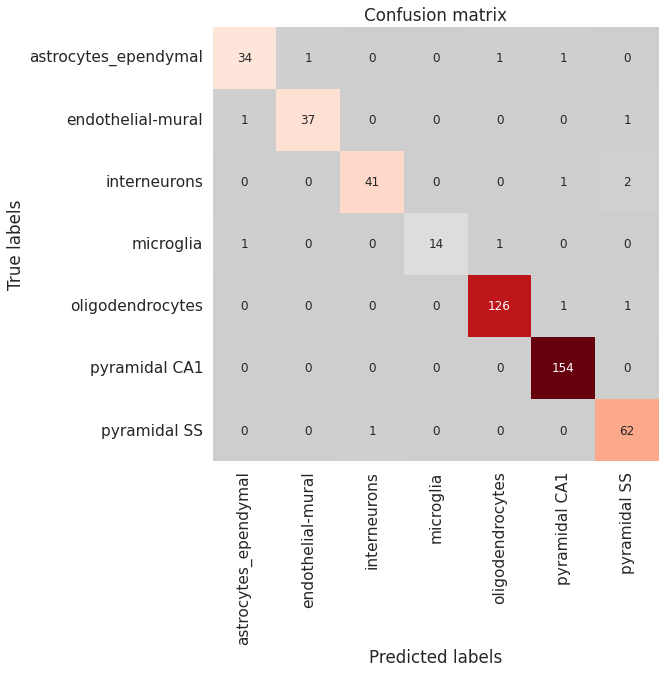

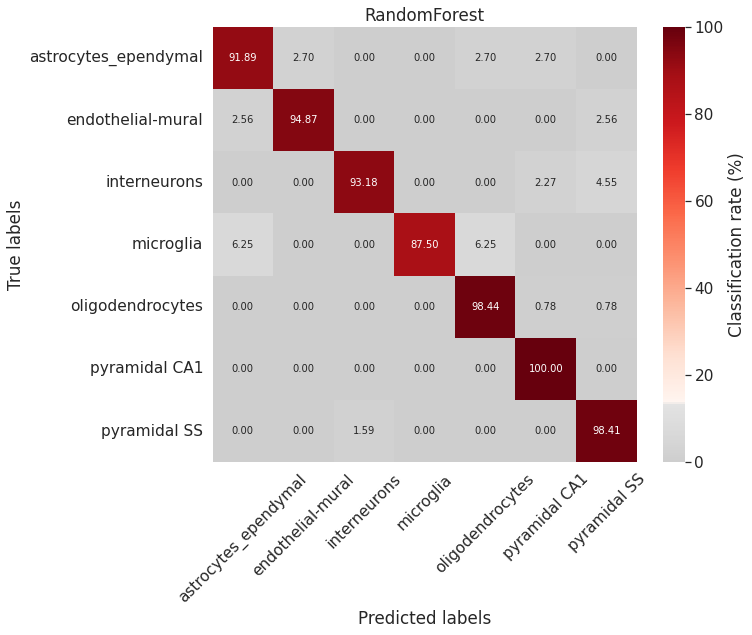

Accuracy: 0.972972972972973: Misclassification: 0.027027027027026973
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.92      0.93        37
   endothelial-mural       0.97      0.95      0.96        39
        interneurons       0.98      0.93      0.95        44
           microglia       1.00      0.88      0.93        16
    oligodendrocytes       0.98      0.98      0.98       128
       pyramidal CA1       0.98      1.00      0.99       154
        pyramidal SS       0.94      0.98      0.96        63

            accuracy                           0.97       481
           macro avg       0.97      0.95      0.96       481
        weighted avg       0.97      0.97      0.97       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

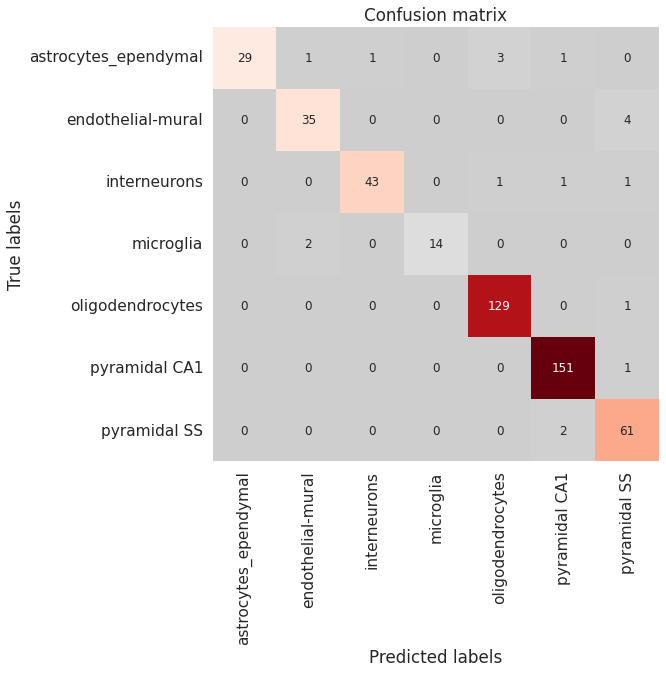

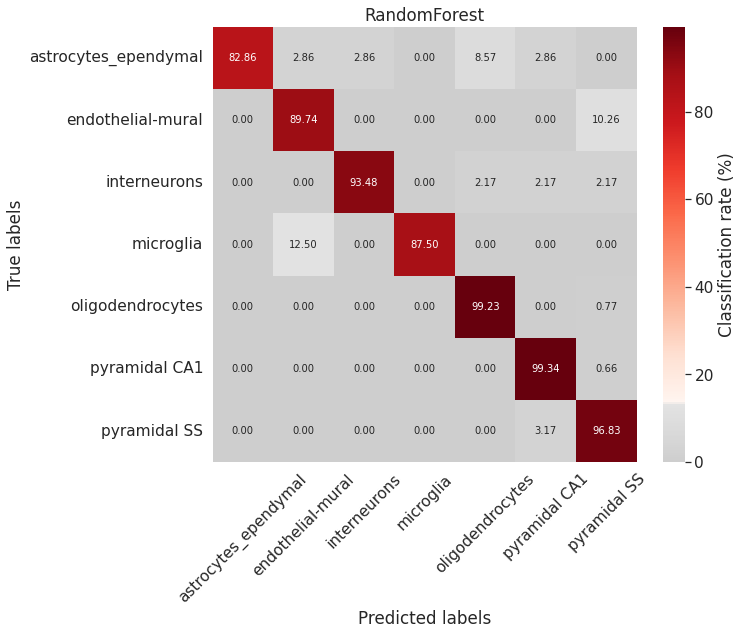

Accuracy: 0.9604989604989606: Misclassification: 0.03950103950103945
                      precision    recall  f1-score   support

astrocytes_ependymal       1.00      0.83      0.91        35
   endothelial-mural       0.92      0.90      0.91        39
        interneurons       0.98      0.93      0.96        46
           microglia       1.00      0.88      0.93        16
    oligodendrocytes       0.97      0.99      0.98       130
       pyramidal CA1       0.97      0.99      0.98       152
        pyramidal SS       0.90      0.97      0.93        63

            accuracy                           0.96       481
           macro avg       0.96      0.93      0.94       481
        weighted avg       0.96      0.96      0.96       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

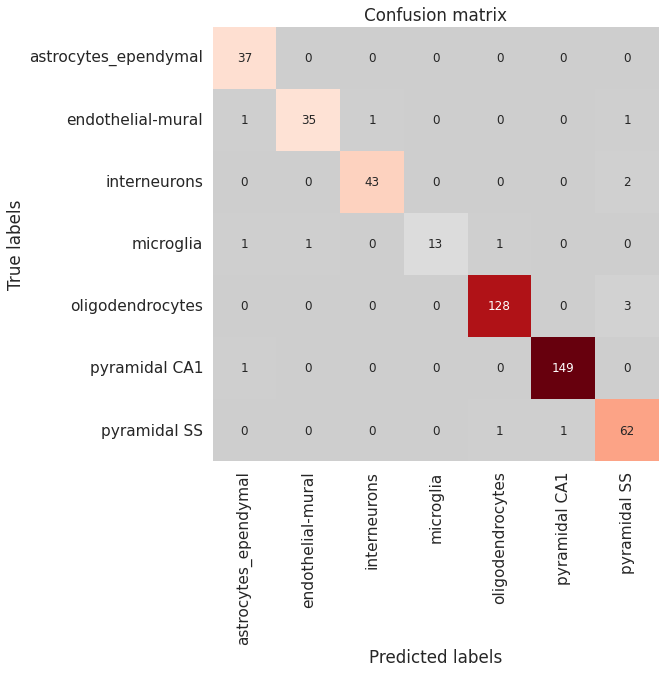

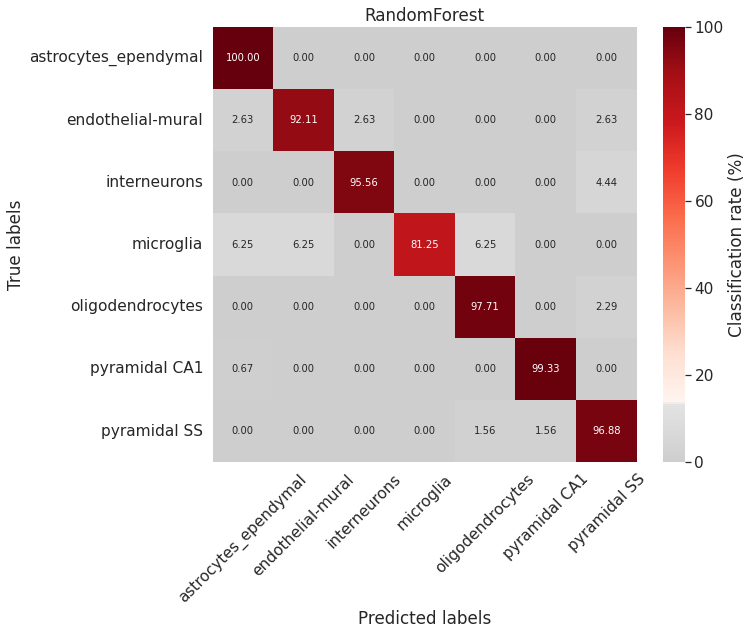

Accuracy: 0.9708939708939709: Misclassification: 0.029106029106029108
                      precision    recall  f1-score   support

astrocytes_ependymal       0.93      1.00      0.96        37
   endothelial-mural       0.97      0.92      0.95        38
        interneurons       0.98      0.96      0.97        45
           microglia       1.00      0.81      0.90        16
    oligodendrocytes       0.98      0.98      0.98       131
       pyramidal CA1       0.99      0.99      0.99       150
        pyramidal SS       0.91      0.97      0.94        64

            accuracy                           0.97       481
           macro avg       0.97      0.95      0.95       481
        weighted avg       0.97      0.97      0.97       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

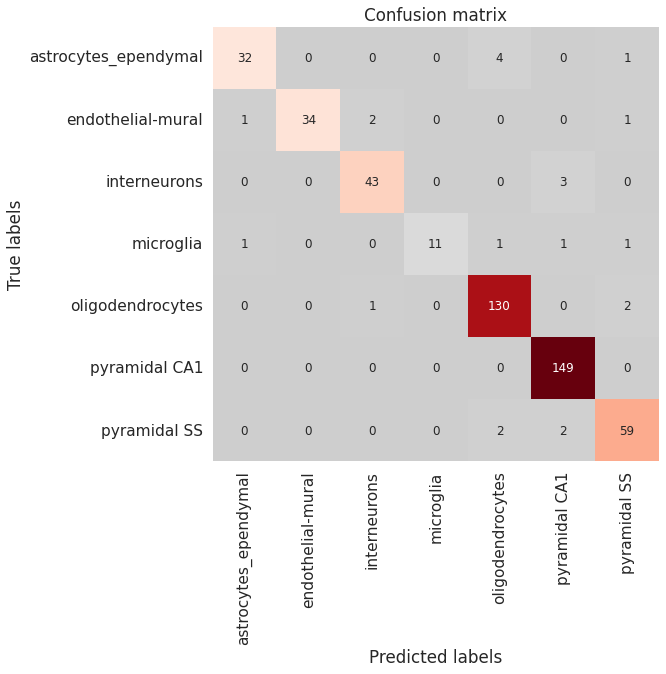

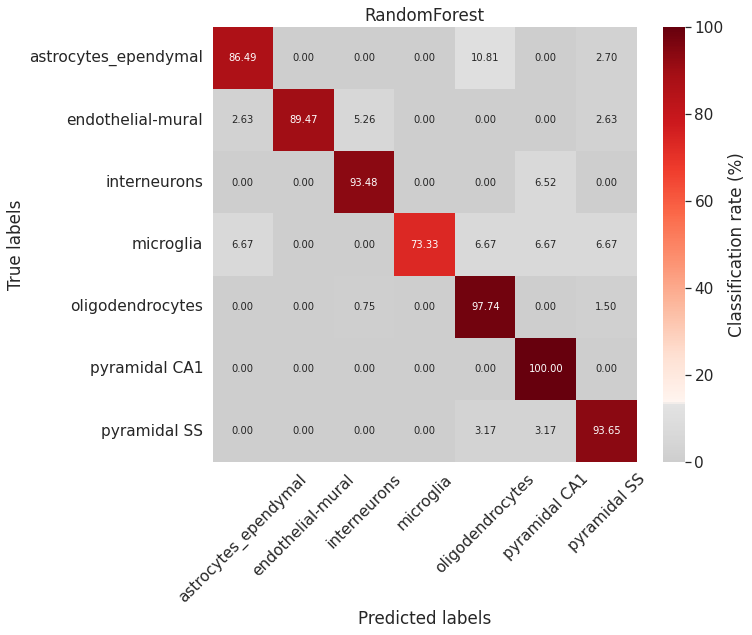

Accuracy: 0.9521829521829522: Misclassification: 0.047817047817047764
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.86      0.90        37
   endothelial-mural       1.00      0.89      0.94        38
        interneurons       0.93      0.93      0.93        46
           microglia       1.00      0.73      0.85        15
    oligodendrocytes       0.95      0.98      0.96       133
       pyramidal CA1       0.96      1.00      0.98       149
        pyramidal SS       0.92      0.94      0.93        63

            accuracy                           0.95       481
           macro avg       0.96      0.91      0.93       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

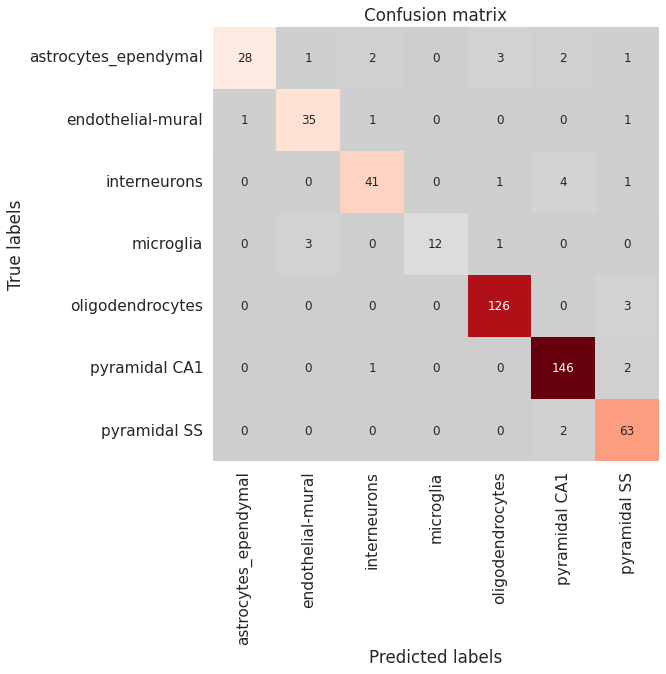

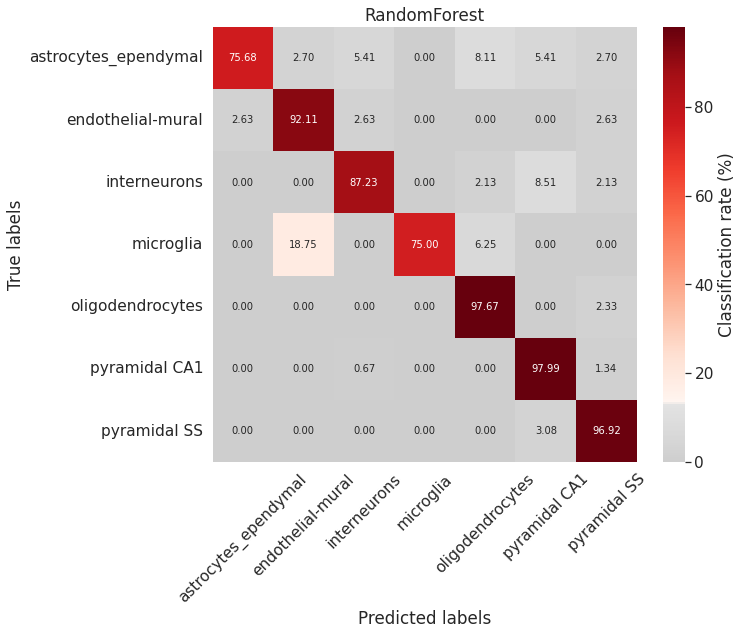

Accuracy: 0.9376299376299376: Misclassification: 0.062370062370062374
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.76      0.85        37
   endothelial-mural       0.90      0.92      0.91        38
        interneurons       0.91      0.87      0.89        47
           microglia       1.00      0.75      0.86        16
    oligodendrocytes       0.96      0.98      0.97       129
       pyramidal CA1       0.95      0.98      0.96       149
        pyramidal SS       0.89      0.97      0.93        65

            accuracy                           0.94       481
           macro avg       0.94      0.89      0.91       481
        weighted avg       0.94      0.94      0.94       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

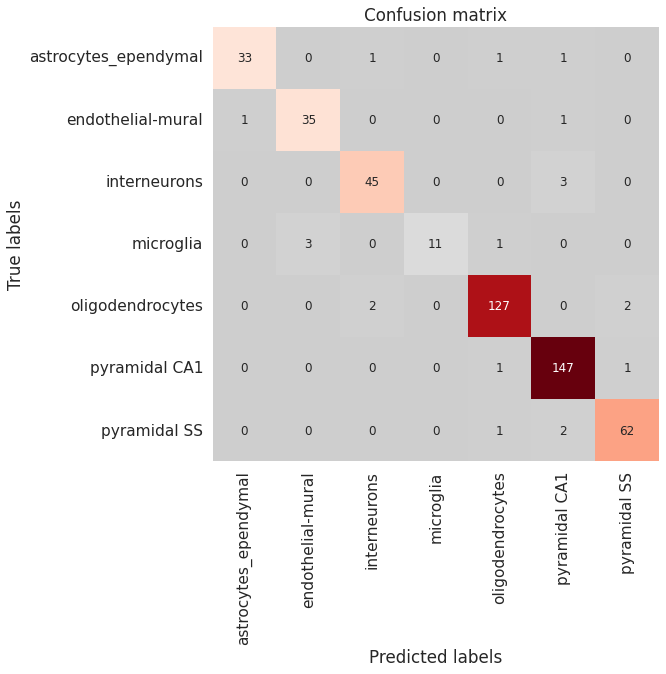

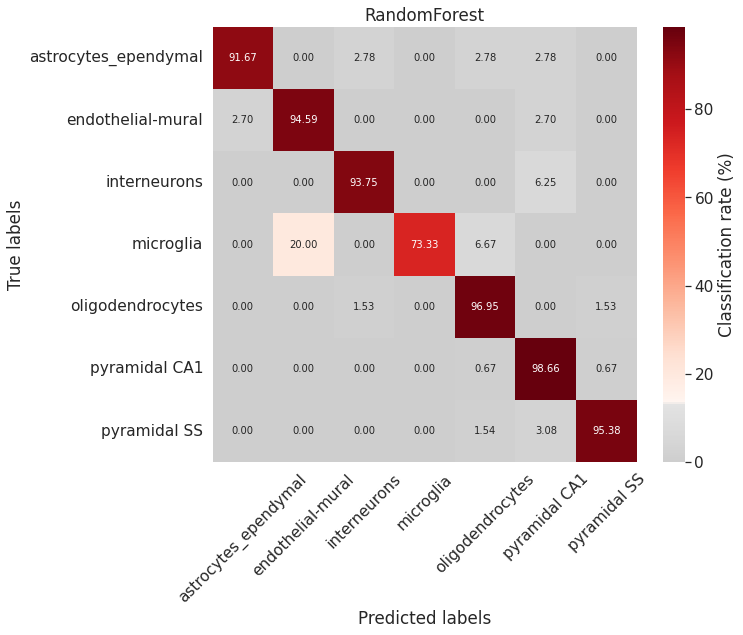

Accuracy: 0.9563409563409564: Misclassification: 0.043659043659043606
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.92      0.94        36
   endothelial-mural       0.92      0.95      0.93        37
        interneurons       0.94      0.94      0.94        48
           microglia       1.00      0.73      0.85        15
    oligodendrocytes       0.97      0.97      0.97       131
       pyramidal CA1       0.95      0.99      0.97       149
        pyramidal SS       0.95      0.95      0.95        65

            accuracy                           0.96       481
           macro avg       0.96      0.92      0.94       481
        weighted avg       0.96      0.96      0.96       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

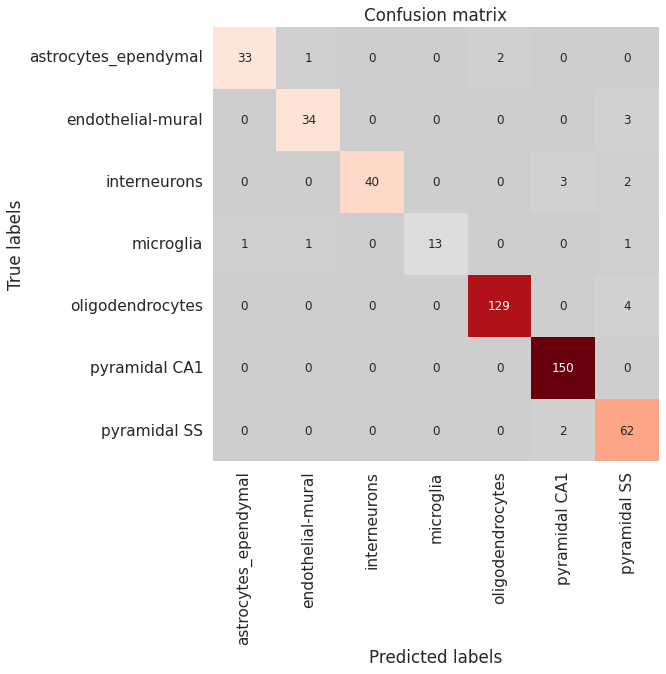

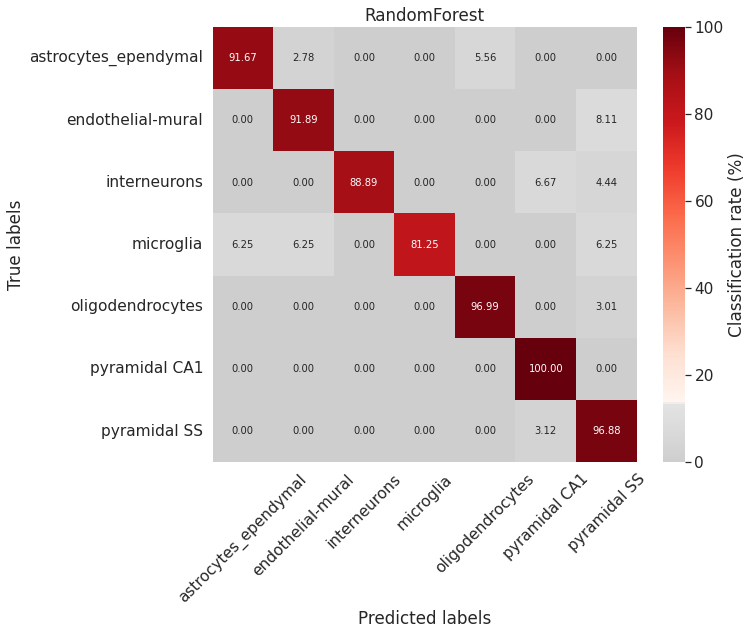

Accuracy: 0.9584199584199584: Misclassification: 0.04158004158004158
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.92      0.94        36
   endothelial-mural       0.94      0.92      0.93        37
        interneurons       1.00      0.89      0.94        45
           microglia       1.00      0.81      0.90        16
    oligodendrocytes       0.98      0.97      0.98       133
       pyramidal CA1       0.97      1.00      0.98       150
        pyramidal SS       0.86      0.97      0.91        64

            accuracy                           0.96       481
           macro avg       0.96      0.93      0.94       481
        weighted avg       0.96      0.96      0.96       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

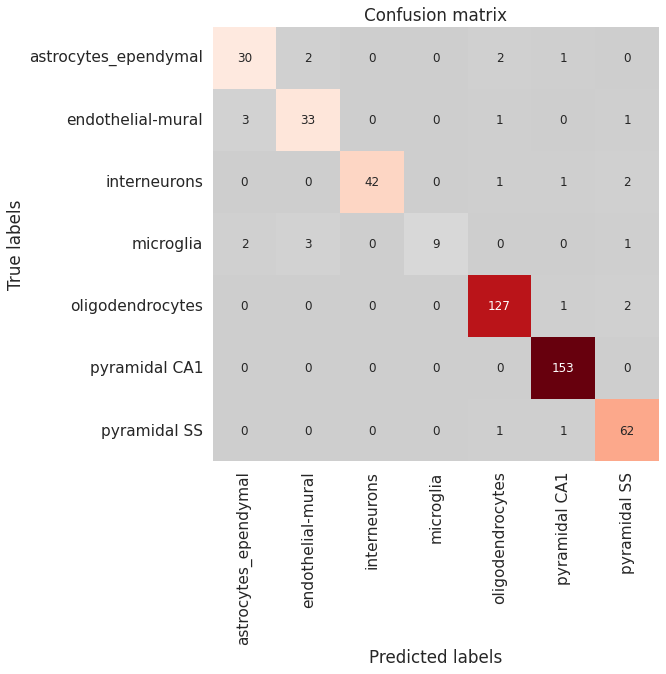

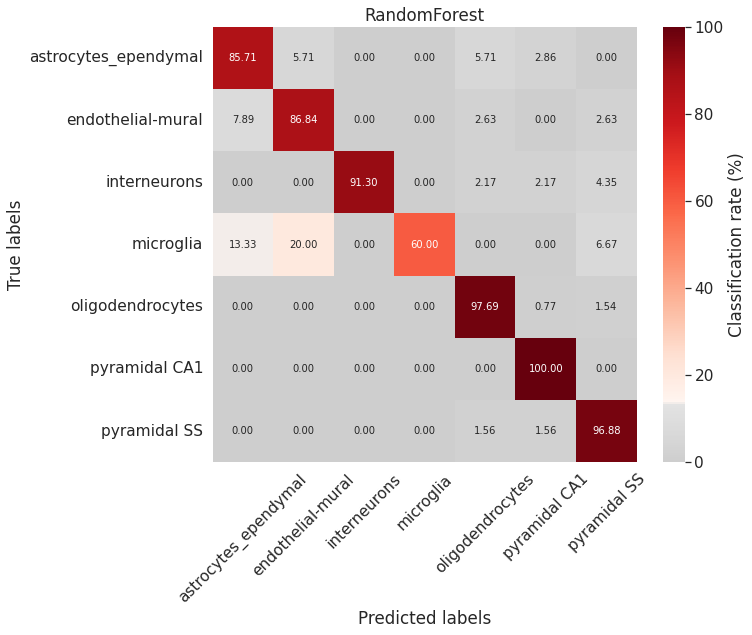

Accuracy: 0.9480249480249481: Misclassification: 0.05197505197505192
                      precision    recall  f1-score   support

astrocytes_ependymal       0.86      0.86      0.86        35
   endothelial-mural       0.87      0.87      0.87        38
        interneurons       1.00      0.91      0.95        46
           microglia       1.00      0.60      0.75        15
    oligodendrocytes       0.96      0.98      0.97       130
       pyramidal CA1       0.97      1.00      0.99       153
        pyramidal SS       0.91      0.97      0.94        64

            accuracy                           0.95       481
           macro avg       0.94      0.88      0.90       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

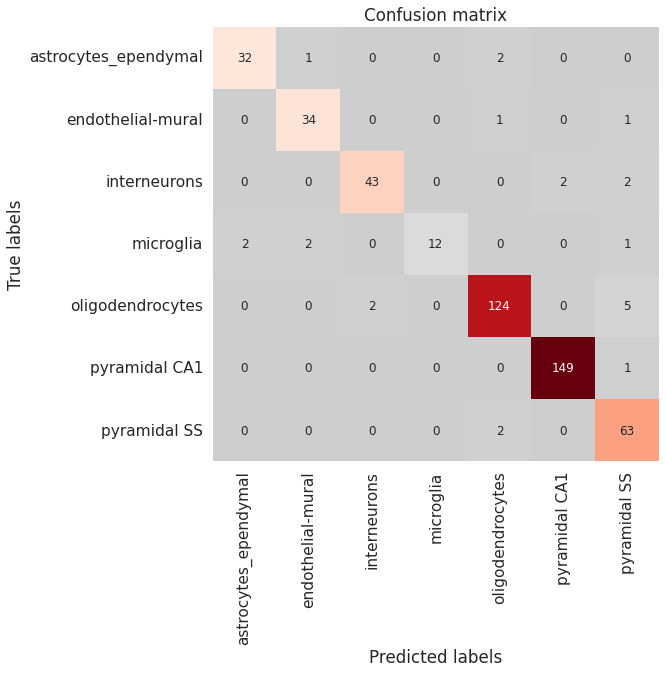

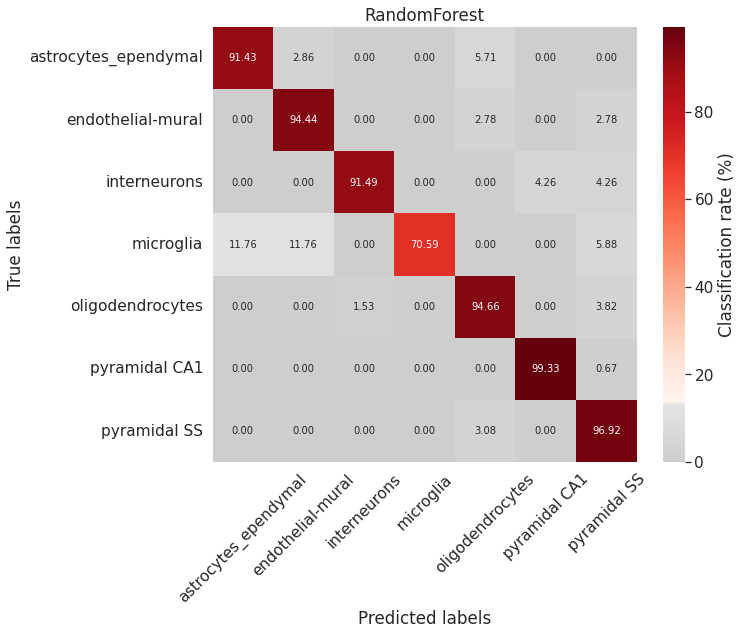

Accuracy: 0.9501039501039501: Misclassification: 0.0498960498960499
                      precision    recall  f1-score   support

astrocytes_ependymal       0.94      0.91      0.93        35
   endothelial-mural       0.92      0.94      0.93        36
        interneurons       0.96      0.91      0.93        47
           microglia       1.00      0.71      0.83        17
    oligodendrocytes       0.96      0.95      0.95       131
       pyramidal CA1       0.99      0.99      0.99       150
        pyramidal SS       0.86      0.97      0.91        65

            accuracy                           0.95       481
           macro avg       0.95      0.91      0.93       481
        weighted avg       0.95      0.95      0.95       481

 * Initialising ...
Running with (Weighted) Random Forest


<Figure size 432x288 with 0 Axes>

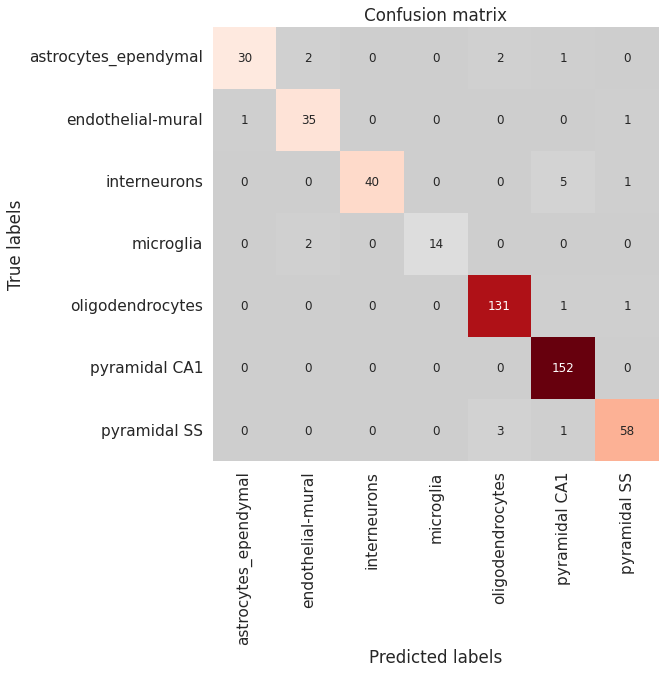

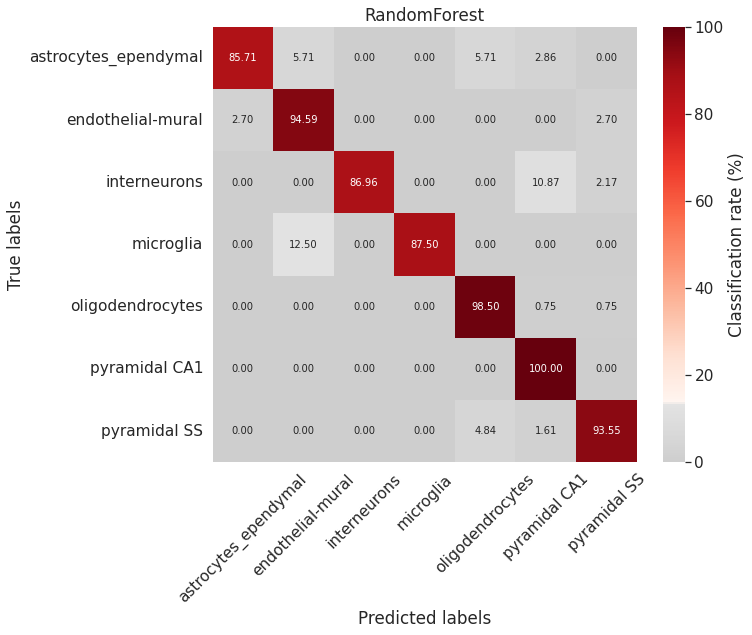

Accuracy: 0.9563409563409564: Misclassification: 0.043659043659043606
                      precision    recall  f1-score   support

astrocytes_ependymal       0.97      0.86      0.91        35
   endothelial-mural       0.90      0.95      0.92        37
        interneurons       1.00      0.87      0.93        46
           microglia       1.00      0.88      0.93        16
    oligodendrocytes       0.96      0.98      0.97       133
       pyramidal CA1       0.95      1.00      0.97       152
        pyramidal SS       0.95      0.94      0.94        62

            accuracy                           0.96       481
           macro avg       0.96      0.92      0.94       481
        weighted avg       0.96      0.96      0.96       481

CPU times: user 5min 42s, sys: 5.97 s, total: 5min 48s
Wall time: 4min 32s


In [17]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    clf = sm.ensemble_learning(train_X_y, group_by="annotation", classifier="RandomForest", balance=True, verbose=True)
    selectedGenes, selectedGenes_dict = sm.gini_importance(train_X_y, clf, group_by="annotation", verbose=True, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_rf_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_rf_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_rf_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Random Forest Marker Visualization', path = viz_save_path + 'smash_rf_markers_{}.png'.format(tryy), markers = smash_markers)

## Train Smash DNN

the data is treated a bit differently than our other models

 * Initialising ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                128032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
activation_1 (Activation)    (None, 

20/20 [==============================] - 0s 9ms/step - loss: 0.6994 - accuracy: 0.9360 - auc: 0.9956 - precision: 0.9988 - recall: 0.4472 - val_loss: 0.7533 - val_accuracy: 0.9439 - val_auc: 0.9972 - val_precision: 1.0000 - val_recall: 0.4761

Epoch 00018: val_loss improved from 0.80579 to 0.75333, saving model to weights/best_model_annotation.h5
Epoch 19/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6644 - accuracy: 0.9470 - auc: 0.9976 - precision: 1.0000 - recall: 0.5112 - val_loss: 0.7480 - val_accuracy: 0.9272 - val_auc: 0.9967 - val_precision: 1.0000 - val_recall: 0.4802

Epoch 00019: val_loss improved from 0.75333 to 0.74795, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6419 - accuracy: 0.9496 - auc: 0.9973 - precision: 1.0000 - recall: 0.5486 - val_loss: 0.7084 - val_accuracy: 0.9356 - val_auc: 0.9970 - val_precision: 0.9963 - val_recall: 0.5572

Epoch 00020: val_loss improved f

20/20 [==============================] - 0s 7ms/step - loss: 0.2598 - accuracy: 0.9854 - auc: 0.9997 - precision: 0.9983 - recall: 0.9256 - val_loss: 0.3397 - val_accuracy: 0.9459 - val_auc: 0.9974 - val_precision: 0.9733 - val_recall: 0.9106

Epoch 00041: val_loss improved from 0.34535 to 0.33967, saving model to weights/best_model_annotation.h5
Epoch 42/100
20/20 [==============================] - 0s 7ms/step - loss: 0.2503 - accuracy: 0.9849 - auc: 0.9997 - precision: 0.9994 - recall: 0.9350 - val_loss: 0.3333 - val_accuracy: 0.9501 - val_auc: 0.9975 - val_precision: 0.9733 - val_recall: 0.9106

Epoch 00042: val_loss improved from 0.33967 to 0.33331, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 9ms/step - loss: 0.2503 - accuracy: 0.9865 - auc: 0.9997 - precision: 0.9978 - recall: 0.9324 - val_loss: 0.3203 - val_accuracy: 0.9501 - val_auc: 0.9975 - val_precision: 0.9756 - val_recall: 0.9148

Epoch 00043: val_loss improved f


Epoch 00064: val_loss did not improve from 0.20710
Epoch 65/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1092 - accuracy: 0.9984 - auc: 1.0000 - precision: 1.0000 - recall: 0.9906 - val_loss: 0.2139 - val_accuracy: 0.9501 - val_auc: 0.9978 - val_precision: 0.9615 - val_recall: 0.9335

Epoch 00065: val_loss did not improve from 0.20710
Epoch 66/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1191 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9984 - recall: 0.9808 - val_loss: 0.2138 - val_accuracy: 0.9522 - val_auc: 0.9975 - val_precision: 0.9575 - val_recall: 0.9376

Epoch 00066: val_loss did not improve from 0.20710
Epoch 67/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1117 - accuracy: 0.9943 - auc: 1.0000 - precision: 0.9989 - recall: 0.9813 - val_loss: 0.2107 - val_accuracy: 0.9522 - val_auc: 0.9974 - val_precision: 0.9595 - val_recall: 0.9356

Epoch 00067: val_loss did not improve from 0.20710
Epoch 68/100
20/20 [====

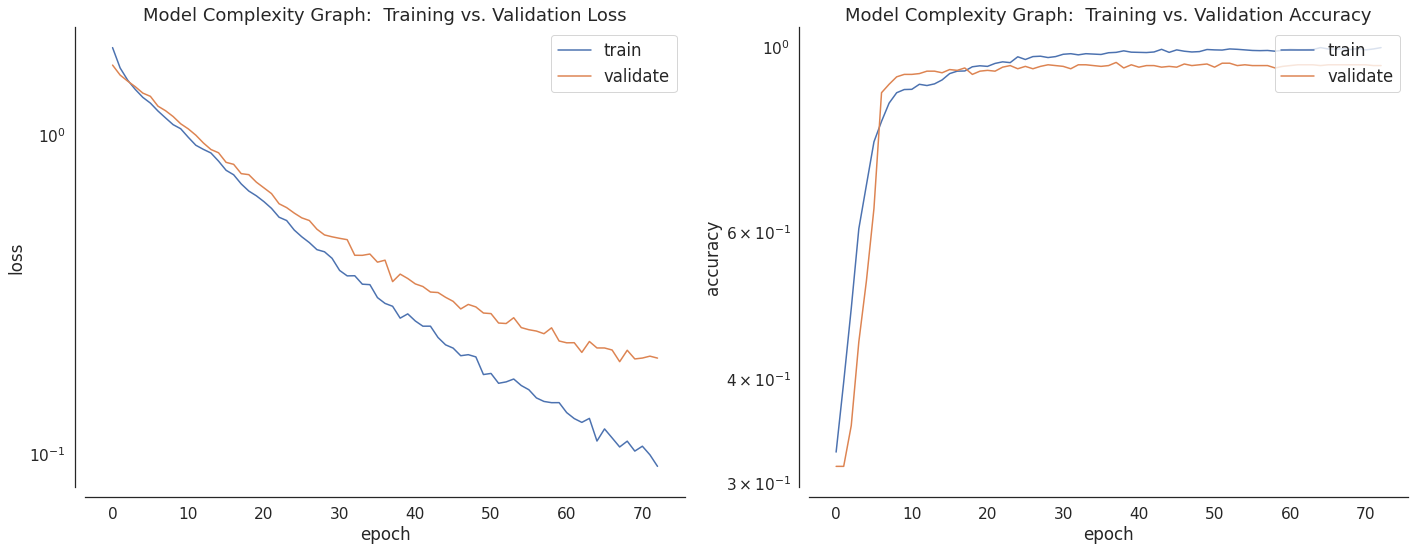

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

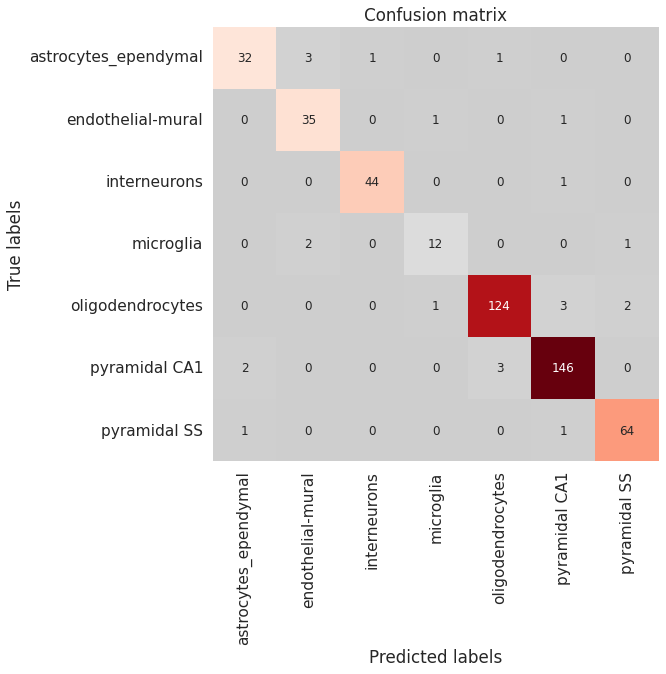

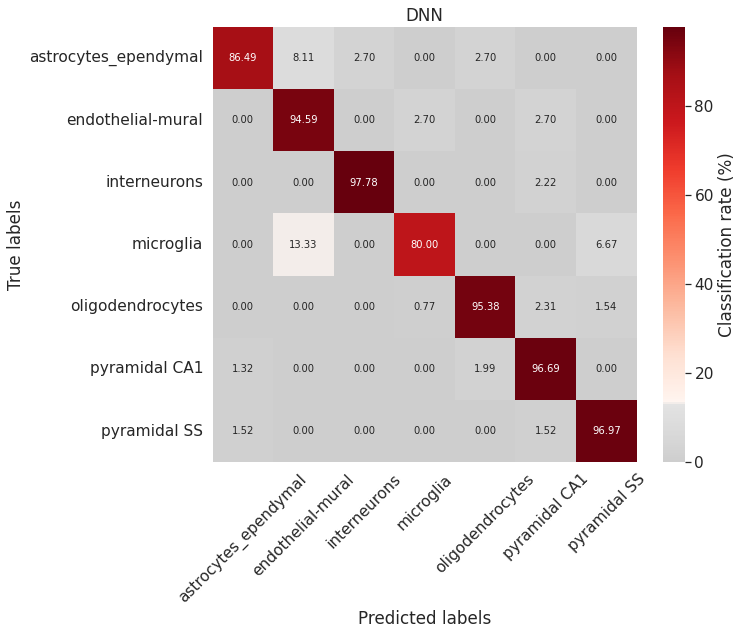

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.86      0.89        37
   endothelial-mural       0.88      0.95      0.91        37
        interneurons       0.98      0.98      0.98        45
           microglia       0.86      0.80      0.83        15
    oligodendrocytes       0.97      0.95      0.96       130
       pyramidal CA1       0.96      0.97      0.96       151
        pyramidal SS       0.96      0.97      0.96        66

            accuracy                           0.95       481
           macro avg       0.93      0.93      0.93       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 2ms/step - loss: 0.1937 - accuracy: 0.9522 - auc: 0.9978 - precision: 0.9619 - recall: 0.9459


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


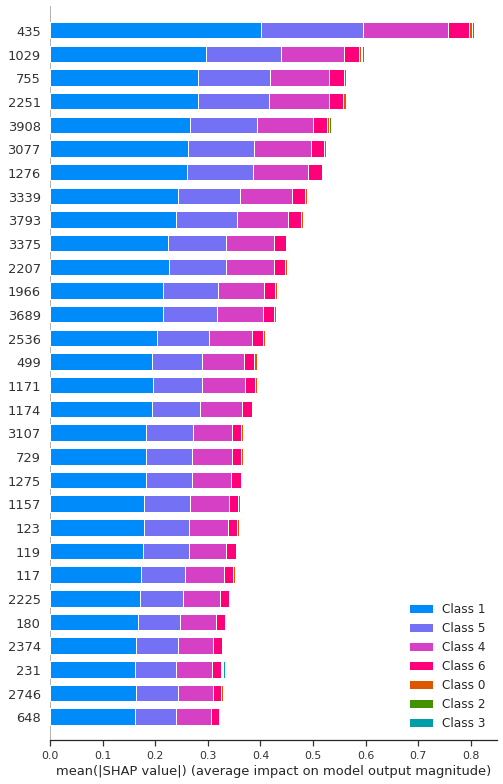

 * Initialising ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                128032    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
activation_5 (Activation)    (None

20/20 [==============================] - 0s 9ms/step - loss: 0.6746 - accuracy: 0.9433 - auc: 0.9961 - precision: 1.0000 - recall: 0.4878 - val_loss: 0.7331 - val_accuracy: 0.9459 - val_auc: 0.9960 - val_precision: 1.0000 - val_recall: 0.4927

Epoch 00019: val_loss improved from 0.77845 to 0.73313, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6548 - accuracy: 0.9470 - auc: 0.9967 - precision: 0.9990 - recall: 0.5174 - val_loss: 0.7274 - val_accuracy: 0.9376 - val_auc: 0.9954 - val_precision: 0.9923 - val_recall: 0.5343

Epoch 00020: val_loss improved from 0.73313 to 0.72738, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 10ms/step - loss: 0.6234 - accuracy: 0.9563 - auc: 0.9972 - precision: 1.0000 - recall: 0.5627 - val_loss: 0.6882 - val_accuracy: 0.9397 - val_auc: 0.9960 - val_precision: 0.9968 - val_recall: 0.6383

Epoch 00021: val_loss improved 

20/20 [==============================] - 0s 8ms/step - loss: 0.2496 - accuracy: 0.9854 - auc: 0.9998 - precision: 0.9978 - recall: 0.9350 - val_loss: 0.3452 - val_accuracy: 0.9480 - val_auc: 0.9975 - val_precision: 0.9668 - val_recall: 0.9085

Epoch 00042: val_loss improved from 0.36508 to 0.34519, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 7ms/step - loss: 0.2509 - accuracy: 0.9880 - auc: 0.9998 - precision: 0.9978 - recall: 0.9246 - val_loss: 0.3543 - val_accuracy: 0.9459 - val_auc: 0.9966 - val_precision: 0.9645 - val_recall: 0.9044

Epoch 00043: val_loss did not improve from 0.34519
Epoch 44/100
20/20 [==============================] - 0s 7ms/step - loss: 0.2441 - accuracy: 0.9896 - auc: 0.9998 - precision: 0.9967 - recall: 0.9386 - val_loss: 0.3492 - val_accuracy: 0.9439 - val_auc: 0.9971 - val_precision: 0.9639 - val_recall: 0.8877

Epoch 00044: val_loss did not improve from 0.34519
Epoch 45/100
20/20 [===============

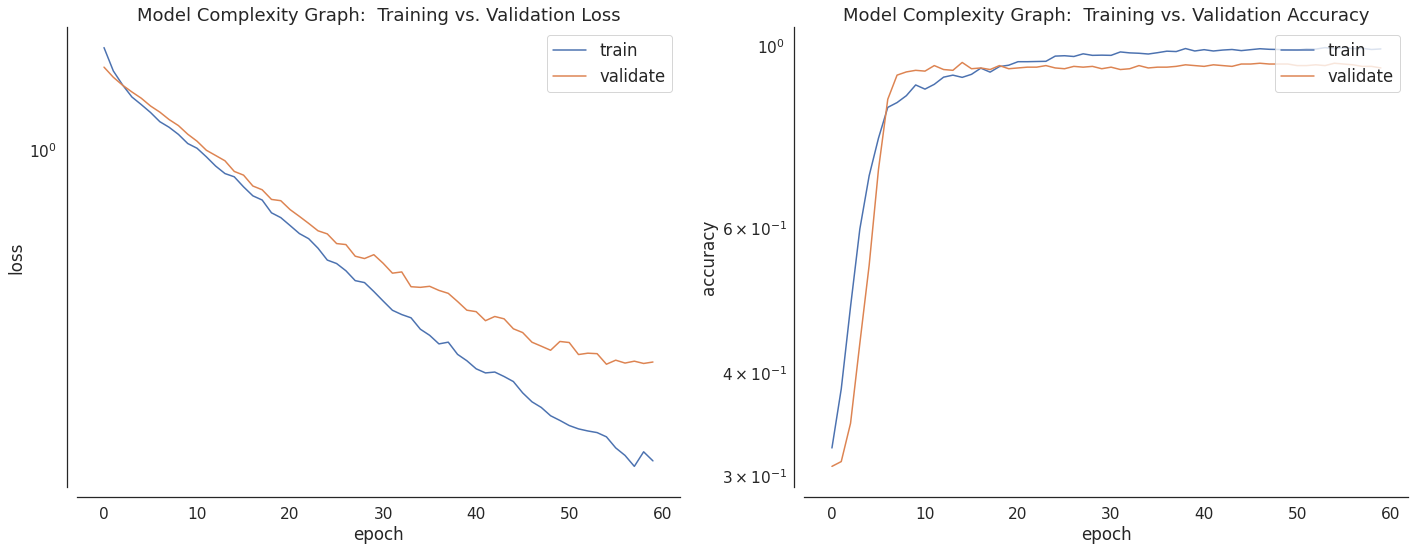

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

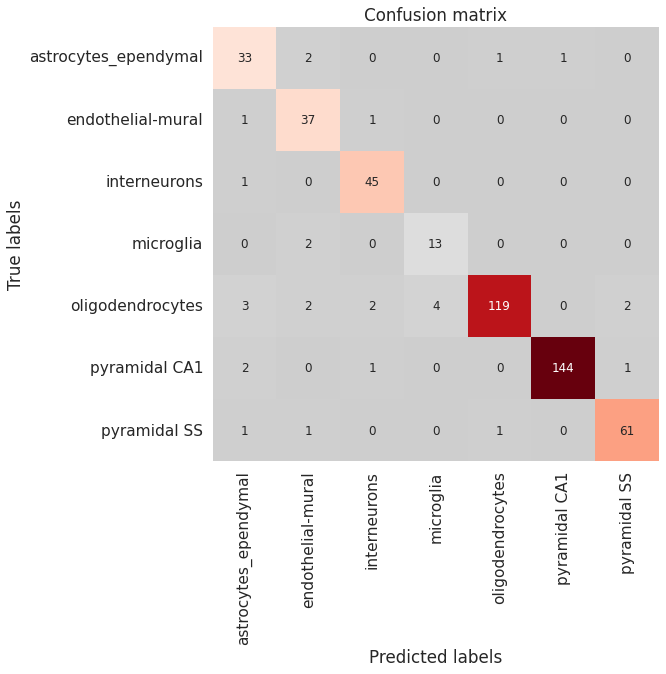

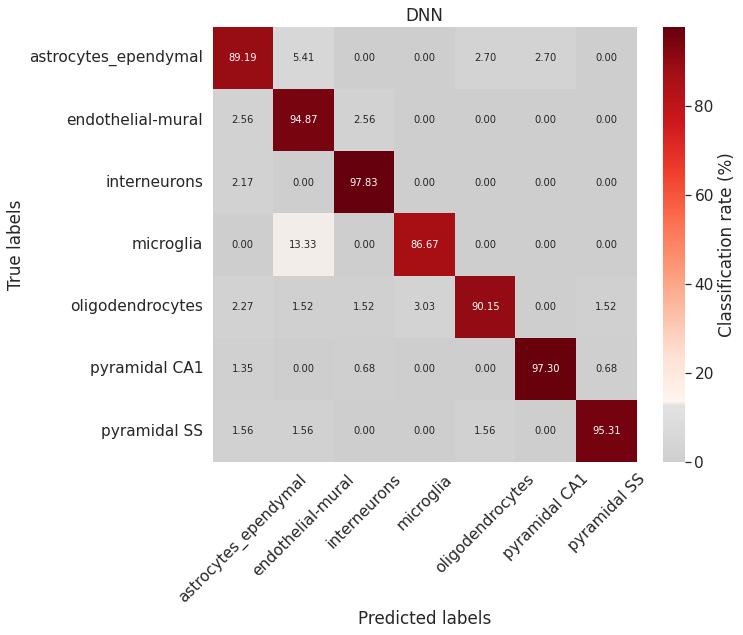

                      precision    recall  f1-score   support

astrocytes_ependymal       0.80      0.89      0.85        37
   endothelial-mural       0.84      0.95      0.89        39
        interneurons       0.92      0.98      0.95        46
           microglia       0.76      0.87      0.81        15
    oligodendrocytes       0.98      0.90      0.94       132
       pyramidal CA1       0.99      0.97      0.98       148
        pyramidal SS       0.95      0.95      0.95        64

            accuracy                           0.94       481
           macro avg       0.89      0.93      0.91       481
        weighted avg       0.94      0.94      0.94       481

16/16 [==============================] - 0s 2ms/step - loss: 0.2634 - accuracy: 0.9522 - auc: 0.9975 - precision: 0.9631 - recall: 0.9231


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


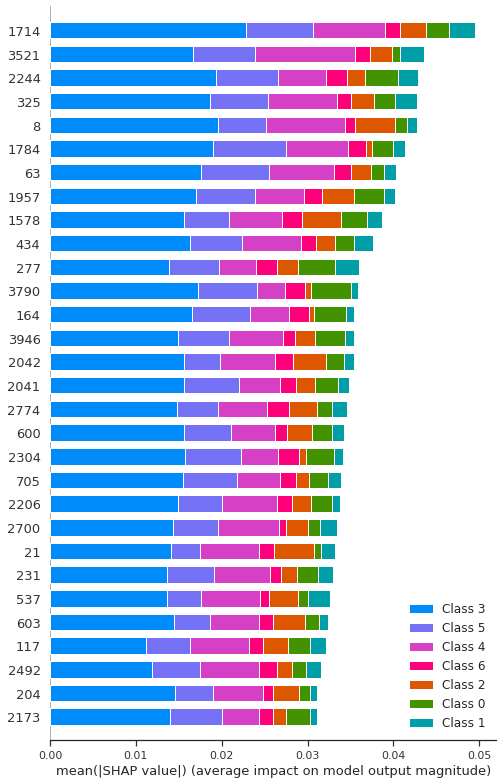

 * Initialising ...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
activation_8 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_9 (Batch (None, 16)                64        
_________________________________________________________________
activation_9 (Activation)    (None

20/20 [==============================] - 0s 8ms/step - loss: 0.6807 - accuracy: 0.9506 - auc: 0.9964 - precision: 0.9989 - recall: 0.4899 - val_loss: 0.7400 - val_accuracy: 0.9563 - val_auc: 0.9968 - val_precision: 0.9956 - val_recall: 0.4678

Epoch 00019: val_loss improved from 0.74879 to 0.73996, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6432 - accuracy: 0.9511 - auc: 0.9972 - precision: 1.0000 - recall: 0.5325 - val_loss: 0.7120 - val_accuracy: 0.9459 - val_auc: 0.9970 - val_precision: 0.9961 - val_recall: 0.5281

Epoch 00020: val_loss improved from 0.73996 to 0.71204, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 9ms/step - loss: 0.6263 - accuracy: 0.9464 - auc: 0.9971 - precision: 0.9991 - recall: 0.5731 - val_loss: 0.6836 - val_accuracy: 0.9563 - val_auc: 0.9967 - val_precision: 0.9932 - val_recall: 0.6091

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 6ms/step - loss: 0.2485 - accuracy: 0.9912 - auc: 0.9998 - precision: 0.9989 - recall: 0.9402 - val_loss: 0.3372 - val_accuracy: 0.9563 - val_auc: 0.9962 - val_precision: 0.9864 - val_recall: 0.9044

Epoch 00042: val_loss improved from 0.34173 to 0.33724, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2486 - accuracy: 0.9854 - auc: 0.9998 - precision: 0.9956 - recall: 0.9308 - val_loss: 0.3392 - val_accuracy: 0.9543 - val_auc: 0.9962 - val_precision: 0.9776 - val_recall: 0.9064

Epoch 00043: val_loss did not improve from 0.33724
Epoch 44/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2309 - accuracy: 0.9891 - auc: 0.9999 - precision: 0.9972 - recall: 0.9360 - val_loss: 0.3062 - val_accuracy: 0.9605 - val_auc: 0.9965 - val_precision: 0.9823 - val_recall: 0.9231

Epoch 00044: val_loss improved from 0.33724 to 0.30624, saving model to weights/best_m

20/20 [==============================] - 0s 6ms/step - loss: 0.1167 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9989 - recall: 0.9839 - val_loss: 0.2169 - val_accuracy: 0.9543 - val_auc: 0.9961 - val_precision: 0.9635 - val_recall: 0.9335

Epoch 00066: val_loss did not improve from 0.20858
Epoch 67/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1090 - accuracy: 0.9958 - auc: 1.0000 - precision: 0.9984 - recall: 0.9880 - val_loss: 0.2218 - val_accuracy: 0.9522 - val_auc: 0.9959 - val_precision: 0.9719 - val_recall: 0.9335

Epoch 00067: val_loss did not improve from 0.20858
Epoch 68/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1050 - accuracy: 0.9974 - auc: 1.0000 - precision: 0.9989 - recall: 0.9891 - val_loss: 0.2097 - val_accuracy: 0.9543 - val_auc: 0.9959 - val_precision: 0.9658 - val_recall: 0.9397

Epoch 00068: val_loss did not improve from 0.20858
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1167 - accura

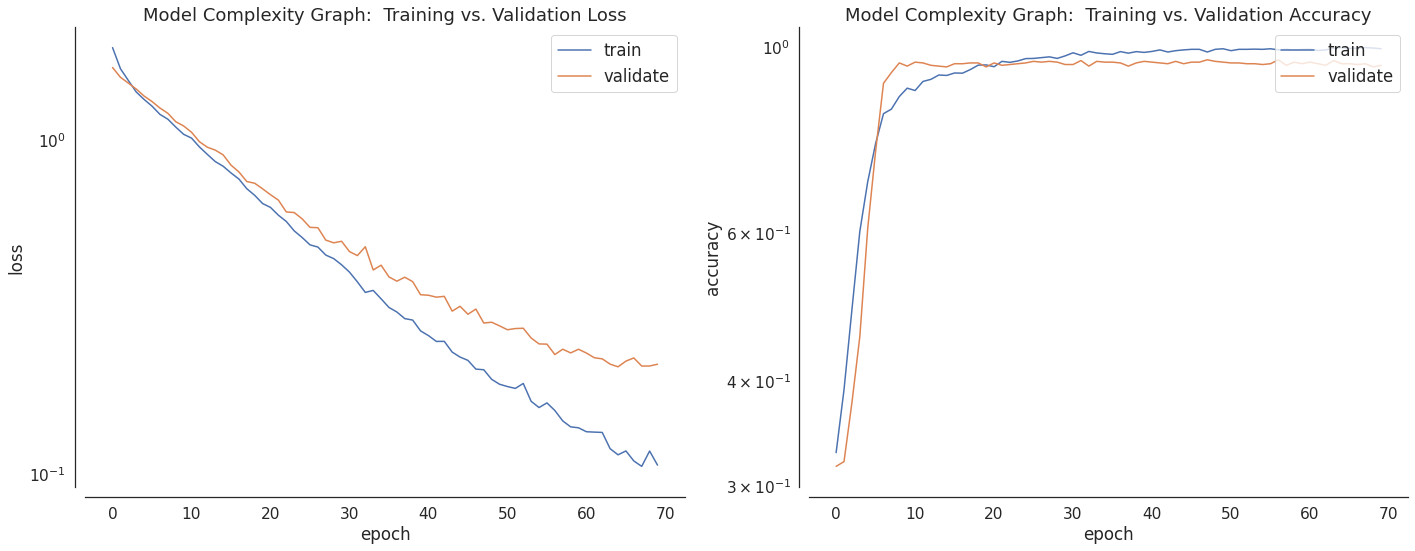

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

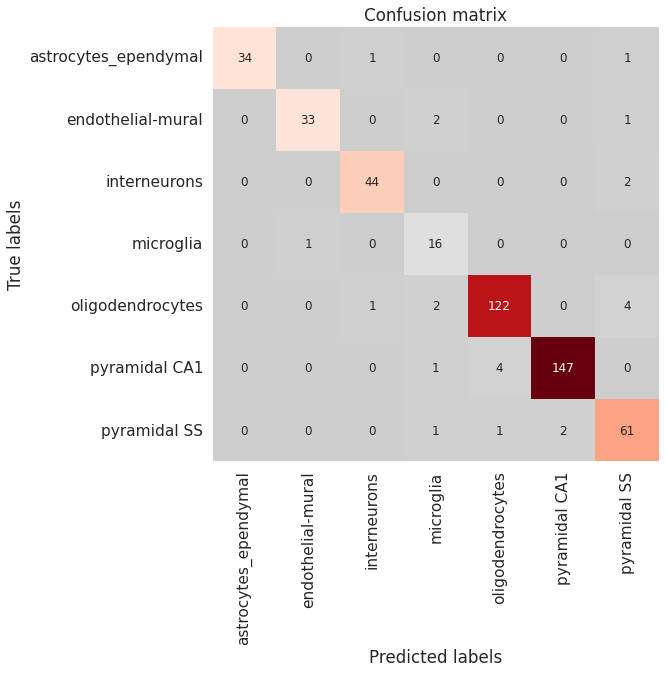

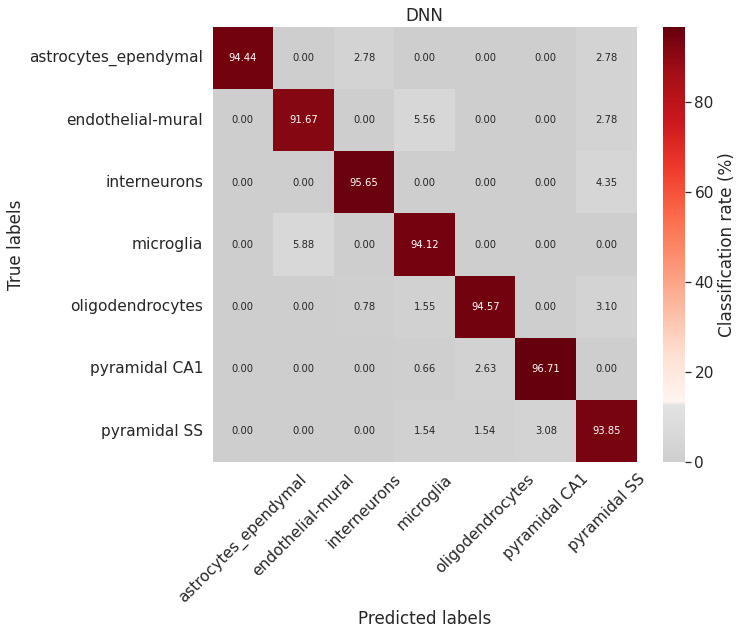

                      precision    recall  f1-score   support

astrocytes_ependymal       1.00      0.94      0.97        36
   endothelial-mural       0.97      0.92      0.94        36
        interneurons       0.96      0.96      0.96        46
           microglia       0.73      0.94      0.82        17
    oligodendrocytes       0.96      0.95      0.95       129
       pyramidal CA1       0.99      0.97      0.98       152
        pyramidal SS       0.88      0.94      0.91        65

            accuracy                           0.95       481
           macro avg       0.93      0.94      0.93       481
        weighted avg       0.95      0.95      0.95       481

16/16 [==============================] - 0s 2ms/step - loss: 0.2086 - accuracy: 0.9543 - auc: 0.9963 - precision: 0.9762 - recall: 0.9376


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


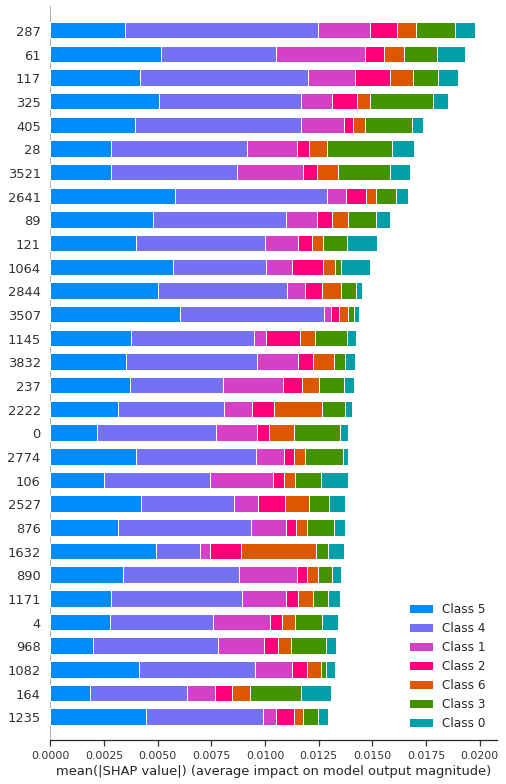

 * Initialising ...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_13 (Batc (None, 16)                64        
_________________________________________________________________
activation_13 (Activation)   (None

20/20 [==============================] - 0s 5ms/step - loss: 0.6686 - accuracy: 0.9496 - auc: 0.9971 - precision: 1.0000 - recall: 0.4966 - val_loss: 0.7378 - val_accuracy: 0.9522 - val_auc: 0.9965 - val_precision: 1.0000 - val_recall: 0.4906

Epoch 00019: val_loss improved from 0.74690 to 0.73781, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 5ms/step - loss: 0.6448 - accuracy: 0.9501 - auc: 0.9972 - precision: 1.0000 - recall: 0.5419 - val_loss: 0.7233 - val_accuracy: 0.9459 - val_auc: 0.9959 - val_precision: 0.9961 - val_recall: 0.5281

Epoch 00020: val_loss improved from 0.73781 to 0.72331, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 4ms/step - loss: 0.6201 - accuracy: 0.9485 - auc: 0.9970 - precision: 1.0000 - recall: 0.5850 - val_loss: 0.6720 - val_accuracy: 0.9522 - val_auc: 0.9963 - val_precision: 0.9936 - val_recall: 0.6445

Epoch 00021: val_loss improved f

Epoch 43/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2520 - accuracy: 0.9860 - auc: 0.9997 - precision: 0.9961 - recall: 0.9340 - val_loss: 0.3374 - val_accuracy: 0.9543 - val_auc: 0.9968 - val_precision: 0.9736 - val_recall: 0.9189

Epoch 00043: val_loss did not improve from 0.33546
Epoch 44/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2321 - accuracy: 0.9917 - auc: 0.9999 - precision: 0.9973 - recall: 0.9459 - val_loss: 0.3276 - val_accuracy: 0.9543 - val_auc: 0.9969 - val_precision: 0.9758 - val_recall: 0.9210

Epoch 00044: val_loss improved from 0.33546 to 0.32755, saving model to weights/best_model_annotation.h5
Epoch 45/100
20/20 [==============================] - 0s 5ms/step - loss: 0.2200 - accuracy: 0.9860 - auc: 0.9998 - precision: 0.9984 - recall: 0.9496 - val_loss: 0.2970 - val_accuracy: 0.9563 - val_auc: 0.9973 - val_precision: 0.9803 - val_recall: 0.9335

Epoch 00045: val_loss improved from 0.32755 to 0.29701, saving model to w


Epoch 00067: val_loss did not improve from 0.20137
Epoch 68/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1069 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9968 - recall: 0.9844 - val_loss: 0.1909 - val_accuracy: 0.9584 - val_auc: 0.9983 - val_precision: 0.9744 - val_recall: 0.9480

Epoch 00068: val_loss improved from 0.20137 to 0.19095, saving model to weights/best_model_annotation.h5
Epoch 69/100
20/20 [==============================] - 0s 5ms/step - loss: 0.1080 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9984 - recall: 0.9849 - val_loss: 0.2168 - val_accuracy: 0.9522 - val_auc: 0.9974 - val_precision: 0.9742 - val_recall: 0.9418

Epoch 00069: val_loss did not improve from 0.19095
Epoch 70/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1024 - accuracy: 0.9958 - auc: 1.0000 - precision: 0.9984 - recall: 0.9886 - val_loss: 0.1994 - val_accuracy: 0.9563 - val_auc: 0.9978 - val_precision: 0.9722 - val_recall: 0.9459

Epoch 00070: val_loss

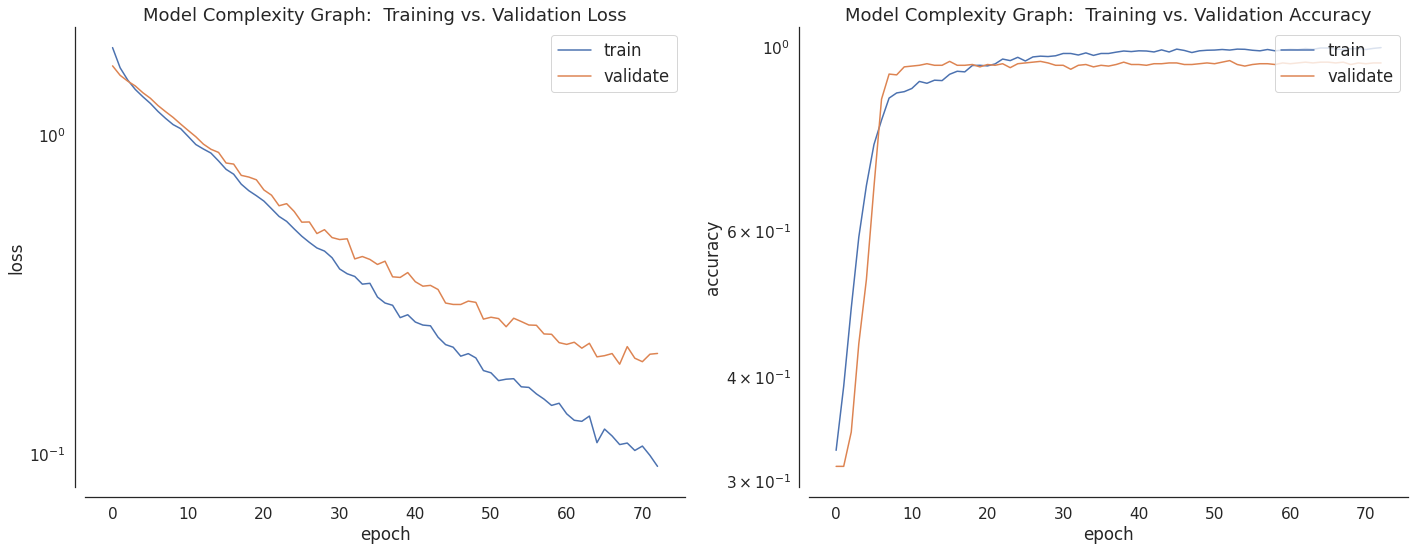

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

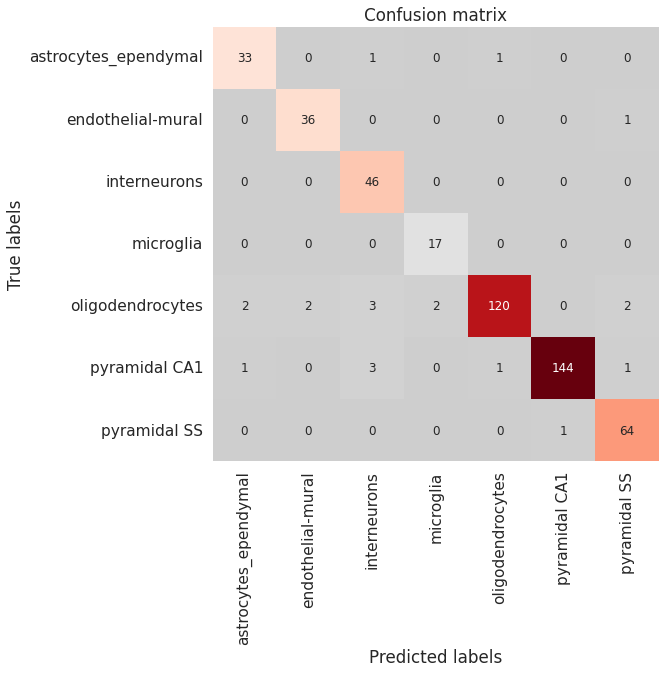

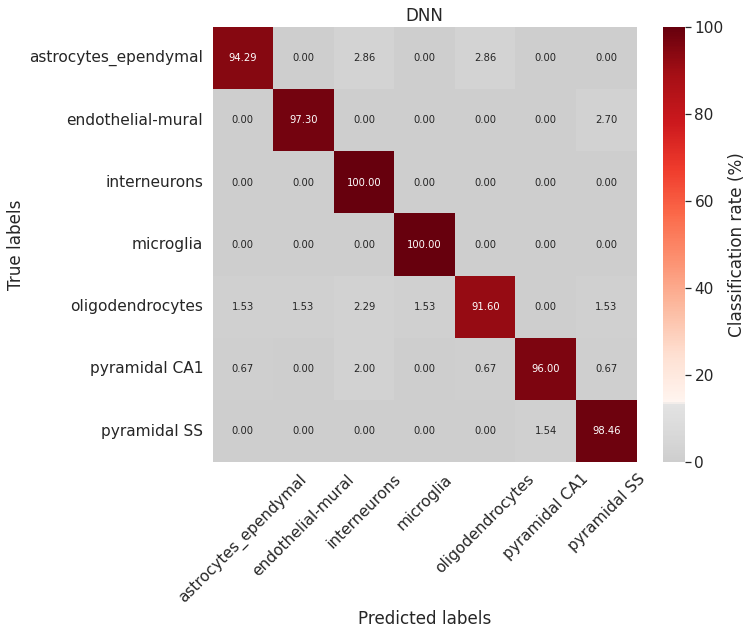

                      precision    recall  f1-score   support

astrocytes_ependymal       0.92      0.94      0.93        35
   endothelial-mural       0.95      0.97      0.96        37
        interneurons       0.87      1.00      0.93        46
           microglia       0.89      1.00      0.94        17
    oligodendrocytes       0.98      0.92      0.95       131
       pyramidal CA1       0.99      0.96      0.98       150
        pyramidal SS       0.94      0.98      0.96        65

            accuracy                           0.96       481
           macro avg       0.93      0.97      0.95       481
        weighted avg       0.96      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1909 - accuracy: 0.9584 - auc: 0.9983 - precision: 0.9744 - recall: 0.9480


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


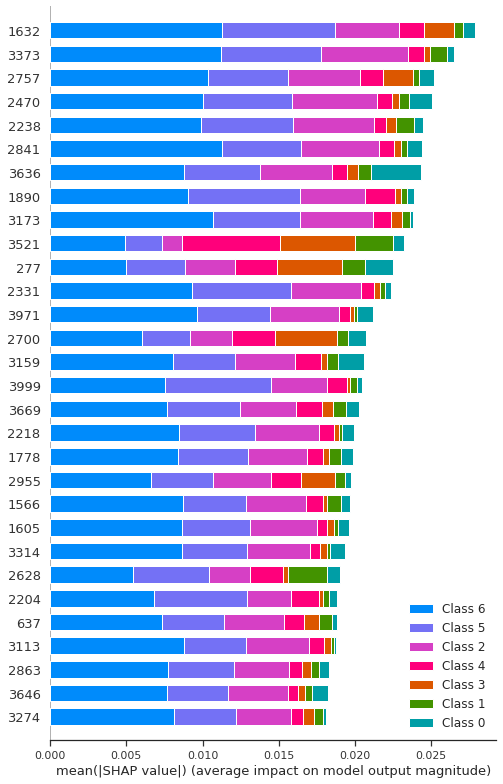

 * Initialising ...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_17 (Batc (None, 16)                64        
_________________________________________________________________
activation_17 (Activation)   (None

20/20 [==============================] - 0s 8ms/step - loss: 0.6679 - accuracy: 0.9516 - auc: 0.9970 - precision: 0.9990 - recall: 0.5122 - val_loss: 0.7304 - val_accuracy: 0.9480 - val_auc: 0.9960 - val_precision: 1.0000 - val_recall: 0.5385

Epoch 00019: val_loss improved from 0.75836 to 0.73037, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 7ms/step - loss: 0.6373 - accuracy: 0.9532 - auc: 0.9975 - precision: 0.9991 - recall: 0.5476 - val_loss: 0.7201 - val_accuracy: 0.9418 - val_auc: 0.9954 - val_precision: 0.9963 - val_recall: 0.5634

Epoch 00020: val_loss improved from 0.73037 to 0.72014, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6128 - accuracy: 0.9516 - auc: 0.9969 - precision: 1.0000 - recall: 0.5829 - val_loss: 0.6670 - val_accuracy: 0.9459 - val_auc: 0.9962 - val_precision: 0.9970 - val_recall: 0.6881

Epoch 00021: val_loss improved f

20/20 [==============================] - 0s 7ms/step - loss: 0.2389 - accuracy: 0.9896 - auc: 0.9999 - precision: 0.9989 - recall: 0.9470 - val_loss: 0.3490 - val_accuracy: 0.9397 - val_auc: 0.9960 - val_precision: 0.9730 - val_recall: 0.8981

Epoch 00042: val_loss improved from 0.35827 to 0.34904, saving model to weights/best_model_annotation.h5
Epoch 43/100
20/20 [==============================] - 0s 8ms/step - loss: 0.2377 - accuracy: 0.9891 - auc: 0.9998 - precision: 0.9989 - recall: 0.9329 - val_loss: 0.3311 - val_accuracy: 0.9501 - val_auc: 0.9962 - val_precision: 0.9732 - val_recall: 0.9064

Epoch 00043: val_loss improved from 0.34904 to 0.33107, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 8ms/step - loss: 0.2318 - accuracy: 0.9865 - auc: 0.9998 - precision: 0.9983 - recall: 0.9381 - val_loss: 0.3176 - val_accuracy: 0.9459 - val_auc: 0.9963 - val_precision: 0.9712 - val_recall: 0.9127

Epoch 00044: val_loss improved f

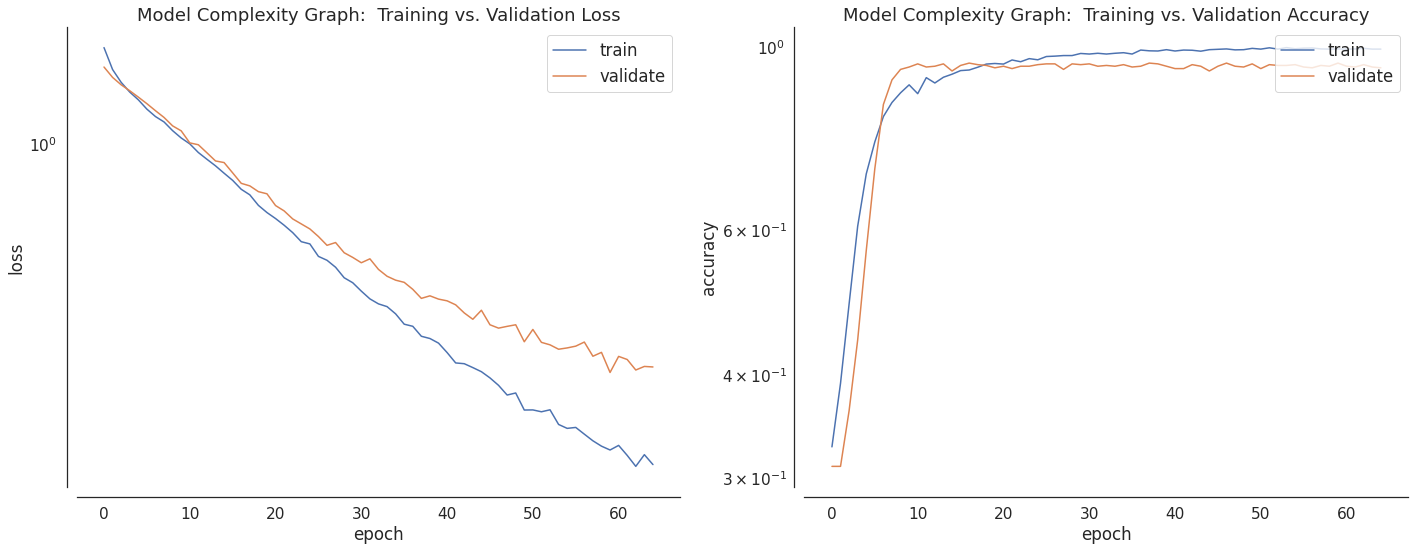

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

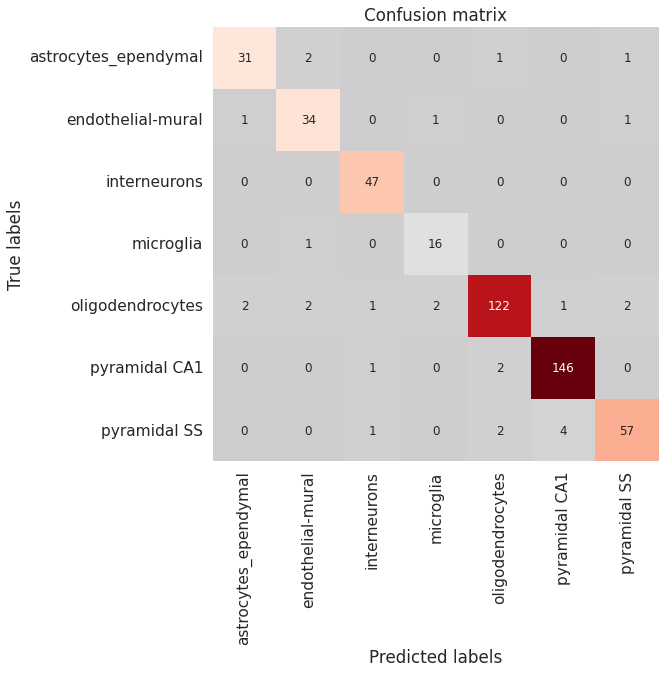

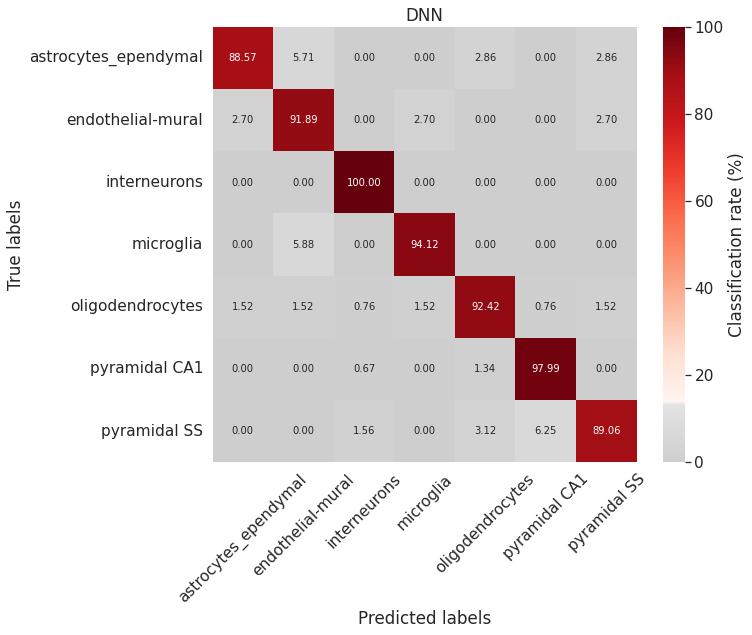

                      precision    recall  f1-score   support

astrocytes_ependymal       0.91      0.89      0.90        35
   endothelial-mural       0.87      0.92      0.89        37
        interneurons       0.94      1.00      0.97        47
           microglia       0.84      0.94      0.89        17
    oligodendrocytes       0.96      0.92      0.94       132
       pyramidal CA1       0.97      0.98      0.97       149
        pyramidal SS       0.93      0.89      0.91        64

            accuracy                           0.94       481
           macro avg       0.92      0.93      0.93       481
        weighted avg       0.94      0.94      0.94       481

16/16 [==============================] - 0s 2ms/step - loss: 0.2245 - accuracy: 0.9543 - auc: 0.9966 - precision: 0.9618 - recall: 0.9418


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


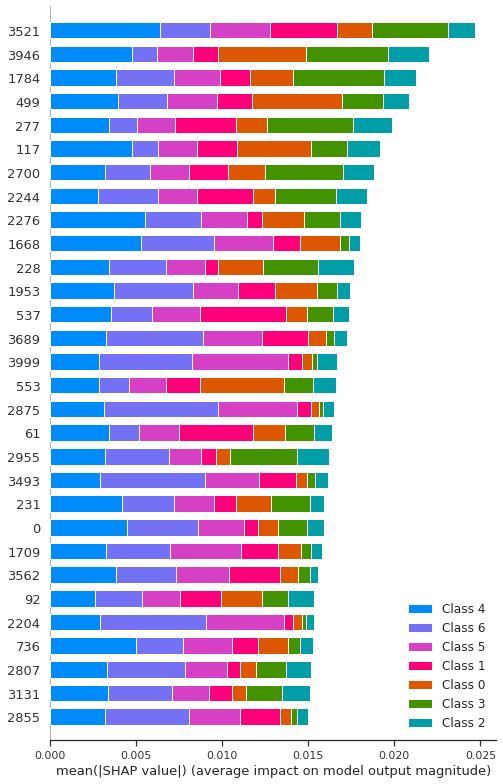

 * Initialising ...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_20 (Batc (None, 32)                128       
_________________________________________________________________
activation_20 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_21 (Batc (None, 16)                64        
_________________________________________________________________
activation_21 (Activation)   (Non

20/20 [==============================] - 0s 5ms/step - loss: 0.6715 - accuracy: 0.9444 - auc: 0.9965 - precision: 1.0000 - recall: 0.4956 - val_loss: 0.7240 - val_accuracy: 0.9647 - val_auc: 0.9975 - val_precision: 0.9957 - val_recall: 0.4823

Epoch 00019: val_loss improved from 0.74724 to 0.72395, saving model to weights/best_model_annotation.h5
Epoch 20/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6534 - accuracy: 0.9459 - auc: 0.9970 - precision: 0.9990 - recall: 0.5200 - val_loss: 0.6872 - val_accuracy: 0.9626 - val_auc: 0.9977 - val_precision: 1.0000 - val_recall: 0.5946

Epoch 00020: val_loss improved from 0.72395 to 0.68725, saving model to weights/best_model_annotation.h5
Epoch 21/100
20/20 [==============================] - 0s 6ms/step - loss: 0.6283 - accuracy: 0.9501 - auc: 0.9967 - precision: 0.9972 - recall: 0.5559 - val_loss: 0.6337 - val_accuracy: 0.9605 - val_auc: 0.9980 - val_precision: 0.9941 - val_recall: 0.7048

Epoch 00021: val_loss improved f


Epoch 00042: val_loss did not improve from 0.31638
Epoch 43/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2452 - accuracy: 0.9865 - auc: 0.9997 - precision: 0.9967 - recall: 0.9412 - val_loss: 0.3098 - val_accuracy: 0.9605 - val_auc: 0.9986 - val_precision: 0.9716 - val_recall: 0.9252

Epoch 00043: val_loss improved from 0.31638 to 0.30985, saving model to weights/best_model_annotation.h5
Epoch 44/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2368 - accuracy: 0.9870 - auc: 0.9998 - precision: 0.9967 - recall: 0.9298 - val_loss: 0.2917 - val_accuracy: 0.9605 - val_auc: 0.9988 - val_precision: 0.9739 - val_recall: 0.9293

Epoch 00044: val_loss improved from 0.30985 to 0.29167, saving model to weights/best_model_annotation.h5
Epoch 45/100
20/20 [==============================] - 0s 6ms/step - loss: 0.2148 - accuracy: 0.9927 - auc: 0.9999 - precision: 0.9995 - recall: 0.9506 - val_loss: 0.2838 - val_accuracy: 0.9688 - val_auc: 0.9987 - val_precisi


Epoch 00066: val_loss improved from 0.18307 to 0.17514, saving model to weights/best_model_annotation.h5
Epoch 67/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1173 - accuracy: 0.9948 - auc: 1.0000 - precision: 0.9974 - recall: 0.9828 - val_loss: 0.1700 - val_accuracy: 0.9667 - val_auc: 0.9992 - val_precision: 0.9745 - val_recall: 0.9522

Epoch 00067: val_loss improved from 0.17514 to 0.16998, saving model to weights/best_model_annotation.h5
Epoch 68/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1104 - accuracy: 0.9953 - auc: 1.0000 - precision: 0.9984 - recall: 0.9880 - val_loss: 0.1832 - val_accuracy: 0.9584 - val_auc: 0.9988 - val_precision: 0.9744 - val_recall: 0.9480

Epoch 00068: val_loss did not improve from 0.16998
Epoch 69/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1110 - accuracy: 0.9932 - auc: 1.0000 - precision: 0.9984 - recall: 0.9813 - val_loss: 0.1795 - val_accuracy: 0.9667 - val_auc: 0.9987 - val_precisi

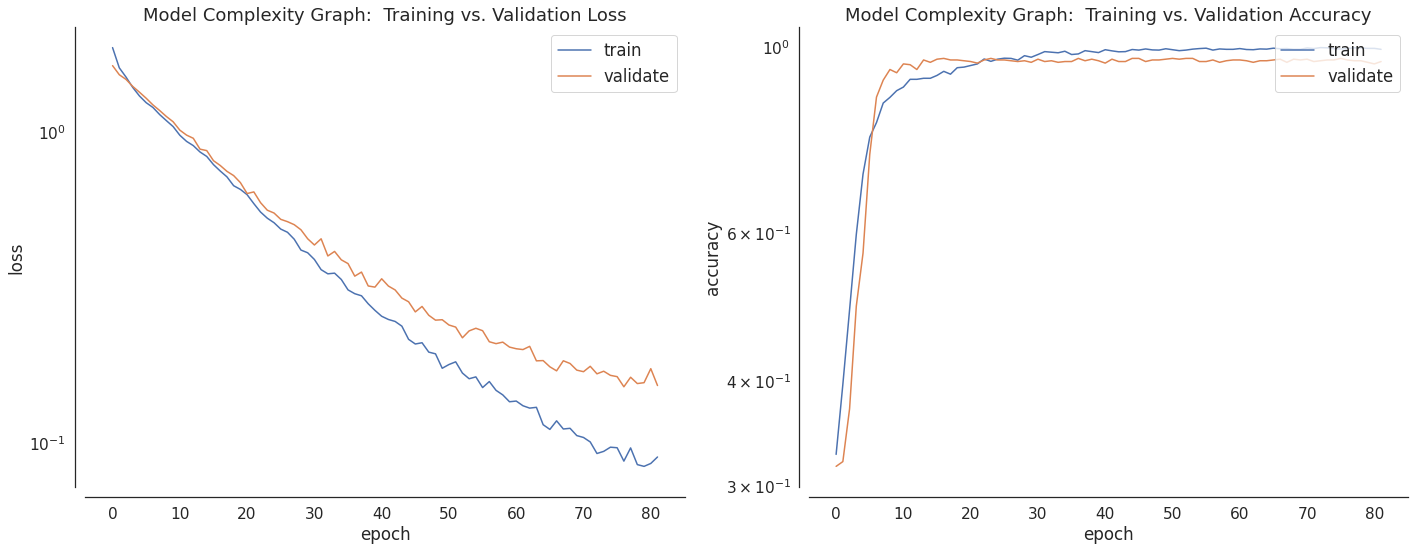

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


<Figure size 432x288 with 0 Axes>

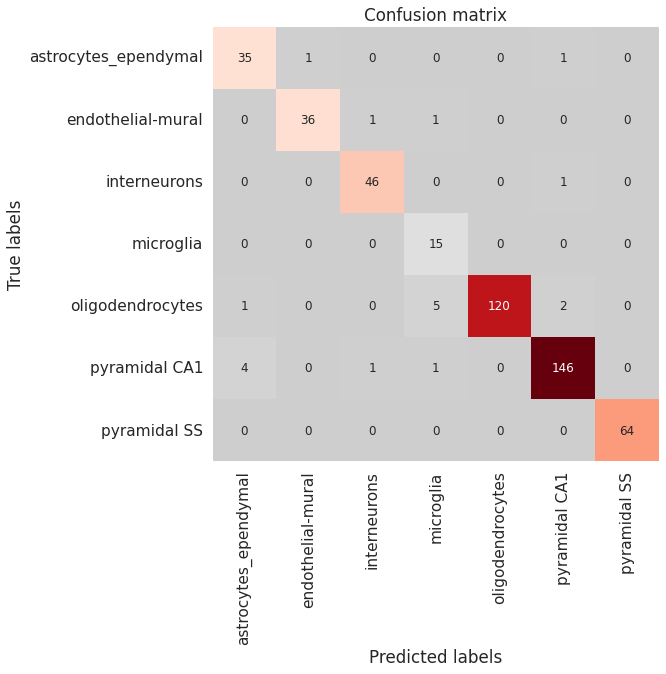

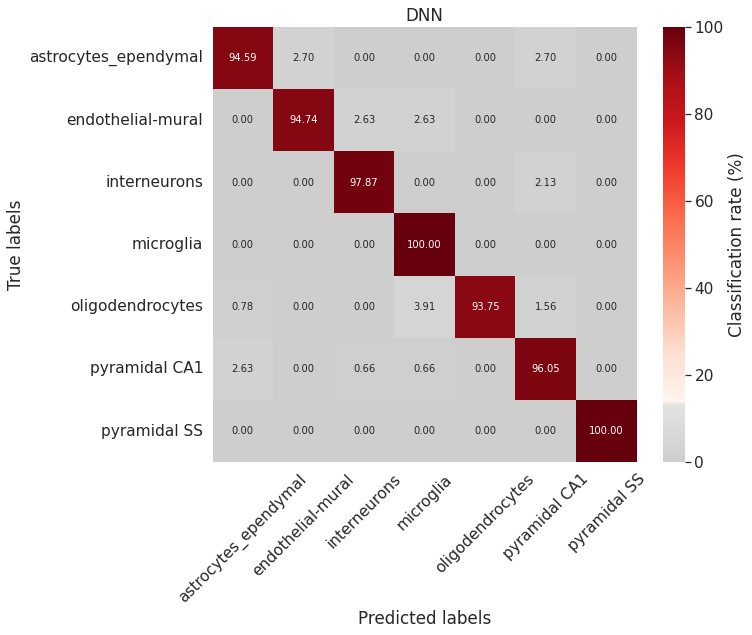

                      precision    recall  f1-score   support

astrocytes_ependymal       0.88      0.95      0.91        37
   endothelial-mural       0.97      0.95      0.96        38
        interneurons       0.96      0.98      0.97        47
           microglia       0.68      1.00      0.81        15
    oligodendrocytes       1.00      0.94      0.97       128
       pyramidal CA1       0.97      0.96      0.97       152
        pyramidal SS       1.00      1.00      1.00        64

            accuracy                           0.96       481
           macro avg       0.92      0.97      0.94       481
        weighted avg       0.97      0.96      0.96       481

16/16 [==============================] - 0s 1ms/step - loss: 0.1510 - accuracy: 0.9647 - auc: 0.9989 - precision: 0.9706 - recall: 0.9605


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


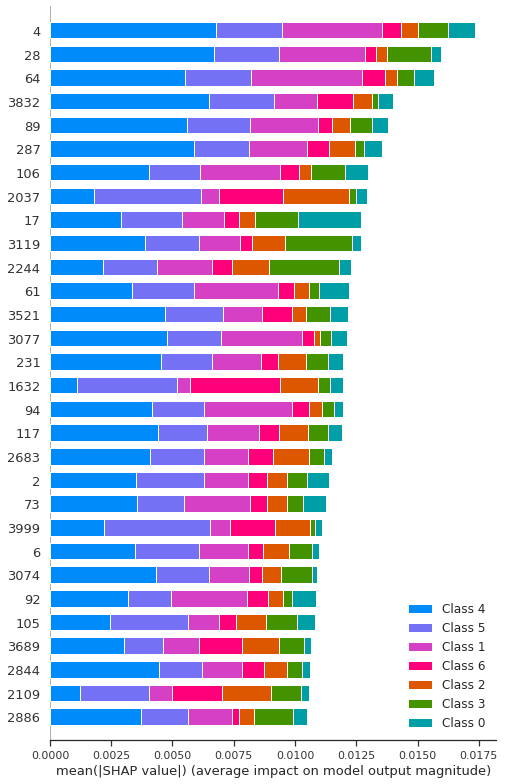

 * Initialising ...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 32)                128032    
_________________________________________________________________
batch_normalization_24 (Batc (None, 32)                128       
_________________________________________________________________
activation_24 (Activation)   (None, 32)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
batch_normalization_25 (Batc (None, 16)                64        
_________________________________________________________________
activation_25 (Activation)   (Non

OSError: Unable to create file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [18]:
%%time
for tryy in range(1,num_times+1):
    # The smashpy methods set global seeds that mess with sampling. These seeds are used 
    # to stop those methods from using the same global seed over and over.
    np.random.seed(possible_seeds[seed_index])
    seed_index += 1
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    train_X_y = adata[np.concatenate([train_indices, val_indices]), :]
    sm = smashpy.smashpy()
    sm.DNN(train_X_y, group_by="annotation", model=None, balance=True, verbose=True, save=False)
    selectedGenes, selectedGenes_dict = sm.run_shap(train_X_y, group_by="annotation", model=None, verbose=True, pct=0.1, restrict_top=("global", k))
    # since this selects k per class, need select randomly from each classes
    smash_markers = adata.var.index.get_indexer(selectedGenes)

    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = smash_markers)
    np.save(model_save_path + 'smash_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'smash_markers_{}.npy'.format(tryy), smash_markers)
    np.save(model_save_path + 'experiment_data_folds/smash_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Smash Marker Visualization', path = viz_save_path + 'smash_markers_{}.png'.format(tryy), markers = smash_markers)

In [19]:
# The smashpy methods set global seeds that mess with sampling. These seeds are used 
# to stop those methods from using the same global seed over and over.
np.random.seed(possible_seeds[seed_index])
seed_index += 1

## Train RankCorr

In [20]:
for tryy in range(1,num_times+1):
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    data = Rocks(X_train, y_train)
    lamb = 4.7# this can be whatever

    rankcorr_markers = data.CSrankMarkers(lamb=lamb, writeOut=False, keepZeros=False, onlyNonZero=False)
    if len(rankcorr_markers) < k:
        raise Exception("Increase lamb for rank corr procedure")
    if len(rankcorr_markers) > k:
        rankcorr_markers = rankcorr_markers[:k]
    geneNames = np.array(adata.var.index)
    data.genes = geneNames
    marker_genes = data.markers_to_genes(rankcorr_markers)
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = rankcorr_markers)
    np.save(model_save_path + 'rankcorr_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'rankcorr_markers_{}.npy'.format(tryy), rankcorr_markers)
    np.save(model_save_path + 'experiment_data_folds/rankcorr_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'RankCorr Marker Visualization', path = viz_save_path + 'rankcorr_markers_{}.png'.format(tryy), markers = rankcorr_markers)

## Train L1 VAE

In [ ]:
feature_std = torch.tensor(X).std(dim = 0)
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_l1_diag(input_size, hidden_layer_size, z_size, batch_norm = batch_norm)
    tmp_path = model_save_path + 'l1_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, min_epochs = 25, 
                     max_epochs = 100, auto_lr = True, early_stopping_patience = 4, precision = precision)
    l1_markers = model.markers(feature_std = feature_std.to(model.device), k = k).clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = l1_markers)
    np.save(model_save_path + 'l1_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'l1_vae_markers_{}.npy'.format(tryy), l1_markers)
    np.save(model_save_path + 'experiment_data_folds/l1_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'L1 VAE Marker Visualization', path = viz_save_path + 'l1_vae_markers_{}.png'.format(tryy), markers = l1_markers)

## Train Global Gate

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers=num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = VAE_Gumbel_GlobalGate(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, batch_norm = batch_norm)
    tmp_path = model_save_path + 'globalgate_vae_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus = gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.00001, early_stopping_patience =  10, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    globalgate_markers = model.markers().clone().cpu().detach().numpy()
    
 
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = globalgate_markers)
    np.save(model_save_path + 'globalgate_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'globalgate_vae_markers_{}.npy'.format(tryy), globalgate_markers)
    np.save(model_save_path + 'experiment_data_folds/globalgate_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Global Gate VAE Marker Visualization', path = viz_save_path + 'globalgate_vae_markers_{}.png'.format(tryy), markers = globalgate_markers)

## Train MarkerMap Unsupervised

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = MarkerMap(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 1.0, num_classes = None)
    tmp_path = model_save_path + 'marker_map_unsupervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 4, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    unsupervised_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = unsupervised_markers)
    np.save(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_unsupervised_markers_{}.npy'.format(tryy), unsupervised_markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_unsupervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Marker Map Unsupervised Marker Visualization', path = viz_save_path + 'marker_map_unsupervised_markers_{}.png'.format(tryy), markers = unsupervised_markers)

## Train MarkerMap Supervised

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0)
    tmp_path = model_save_path + 'marker_map_supervised_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_supervised_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_supervised_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_supervised_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Supervised Marker Visualization', path = viz_save_path + 'marker_map_supervised_markers_{}.png'.format(tryy), markers = markers)

## MakerMap Mixed

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    
    model = MarkerMap(input_size, hidden_layer_size, z_size, num_classes = len(encoder.classes_), 
                             k = k, t = global_t, bias = True, temperature_decay=0.95, alpha = 0.95, batch_norm = batch_norm, loss_tradeoff = 0.5)
    tmp_path = model_save_path + 'marker_map_mixed_{}.ckpt'.format(tryy)
    # DO NOT USE IN OTHER WORKLOADS
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=gpus, tpu_cores = tpu_cores, 
                     min_epochs = 25, max_epochs = 100, auto_lr = True, early_stopping_patience = 3, precision = precision, lr_explore_mode = 'linear', num_lr_rates=500)
    markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers)
    np.save(model_save_path + 'marker_map_mixed_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'marker_map_mixed_markers_{}.npy'.format(tryy), markers)
    np.save(model_save_path + 'experiment_data_folds/marker_map_mixed_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'MarkerMap Mixed Supervision Marker Visualization', path = viz_save_path + 'marker_map_mixed_markers_{}.png'.format(tryy), markers = markers)

## Concrete VAE

In [ ]:
for tryy in range(1,num_times+1):
    train_dataloader, val_dataloader, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1, num_workers = num_cores, batch_size = batch_size)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices,:]
    y_test = y[test_indices]

    model = ConcreteVAE_NMSL(input_size, hidden_layer_size, z_size, k = k, t = global_t, bias = True, temperature_decay = 0.9, batch_norm = batch_norm)
    tmp_path = model_save_path + 'concrete_vae_{}.ckpt'.format(tryy)
    train_save_model(model, train_dataloader, val_dataloader, tmp_path, gpus=1, min_epochs = 25, max_epochs = 100, auto_lr = True, max_lr = 0.0001, early_stopping_patience = 3, 
                     lr_explore_mode = 'linear', num_lr_rates = 500, precision = precision)
    concrete_vae_markers = model.markers().clone().cpu().detach().numpy()
    

    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = concrete_vae_markers)
    np.save(model_save_path + 'concrete_vae_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'concrete_vae_markers_{}.npy'.format(tryy), concrete_vae_markers)
    np.save(model_save_path + 'experiment_data_folds/concrete_vae_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'Concrete VAE Marker Visualization', path = viz_save_path + 'concrete_vae_markers_{}.png'.format(tryy), markers = concrete_vae_markers)

## LassoNet



In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
from functools import partial
from lassonet import plot_path

In [ ]:
for tryy in range(1,num_times+1):  
    _, _, _, train_indices, val_indices, test_indices = split_data_into_dataloaders(X, y, 0.7, 0.1)
    X_train = X[train_indices, :]
    y_train = y[train_indices]
    X_val = X[val_indices,:]
    y_val = y[val_indices]
    X_test = X[test_indices,:]
    y_test = y[test_indices]
    model = LassoNetClassifier()
    model.path(X_train, y_train, X_val = X_val, y_val = y_val)
    lasso_net_markers = torch.argsort(model.feature_importances_, descending = True).cpu().numpy()[:k]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = lasso_net_markers)
    np.save(model_save_path + 'lasso_net_results_{}.npy'.format(tryy), results)
    np.save(model_save_path + 'lasso_net_markers_{}.npy'.format(tryy), lasso_net_markers)
    np.save(model_save_path + 'experiment_data_folds/lasso_net_indices_{}.npy'.format(tryy), (train_indices, val_indices, test_indices))

    visualize_save_embedding(X, y, encoder, 'LassoNet Marker Visualization', path = viz_save_path + 'lasso_net_markers_{}.png'.format(tryy), markers = lasso_net_markers)

## Get Model Metrics from KNNs Classifiers

The above just generates metrics for the Random Forests.

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
def generate_metrics_from_saved_files(X, y, folds_path, markers_path, classifier_model, save_path):
    train_indices, val_indices, test_indices = np.load(folds_path, allow_pickle = True)
    markers = np.load(markers_path, allow_pickle = True)
    X_train = X[np.concatenate([train_indices, val_indices]), :]
    y_train = y[np.concatenate([train_indices, val_indices])]
    X_test = X[test_indices, :]
    y_test = y[test_indices]
    results = new_model_metrics(X_train, y_train, X_test, y_test, markers = markers, model = classifier_model)

    np.save(save_path, results)
    return

def batch_generate_metrics_from_saved_files(X, y, format_folds_path, format_markers_path, format_save_path):
    for tryy in range(1, num_times+1):
        classifier_model = KNeighborsClassifier()
        generate_metrics_from_saved_files(X, y, format_folds_path.format(tryy), format_markers_path.format(tryy), classifier_model, format_save_path.format(tryy))
    return

In [23]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/all_markers_indices_{}.npy',
                                  model_save_path+'all_markers_{}.npy',
                                  model_save_path+'all_markers_knn_results_{}.npy')


In [24]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/l1_vae_indices_{}.npy',
                                  model_save_path+'l1_vae_markers_{}.npy',
                                  model_save_path+'l1_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_rf_indices_{}.npy',
                                  model_save_path+'smash_rf_markers_{}.npy',
                                  model_save_path+'smash_rf_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/smash_indices_{}.npy',
                                  model_save_path+'smash_markers_{}.npy',
                                  model_save_path+'smash_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/rankcorr_indices_{}.npy',
                                  model_save_path+'rankcorr_markers_{}.npy',
                                  model_save_path+'rankcorr_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/globalgate_vae_indices_{}.npy',
                                  model_save_path+'globalgate_vae_markers_{}.npy',
                                  model_save_path+'globalgate_vae_knn_results_{}.npy')

batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_unsupervised_indices_{}.npy',
                                  model_save_path+'marker_map_unsupervised_markers_{}.npy',
                                  model_save_path+'marker_map_unsupervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_supervised_indices_{}.npy',
                                  model_save_path+'marker_map_supervised_markers_{}.npy',
                                  model_save_path+'marker_map_supervised_knn_results_{}.npy')


batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/concrete_vae_indices_{}.npy',
                                  model_save_path+'concrete_vae_markers_{}.npy',
                                  model_save_path+'concrete_vae_knn_results_{}.npy')

In [25]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/marker_map_mixed_indices_{}.npy',
                                  model_save_path+'marker_map_mixed_markers_{}.npy',
                                  model_save_path+'marker_map_mixed_knn_results_{}.npy')

In [26]:
batch_generate_metrics_from_saved_files(X, y,
                                  model_save_path+'experiment_data_folds/lasso_net_indices_{}.npy',
                                  model_save_path+'lasso_net_markers_{}.npy',
                                  model_save_path+'lasso_net_knn_results_{}.npy')

# Results and Visualizations

## Accuracies and F1

In [27]:
result_axis = [
 ('All Markers', 'all_markers_results_{}.npy', 'all_markers_knn_results_{}.npy'), 
 ('L1 VAE', 'l1_vae_results_{}.npy', 'l1_vae_knn_results_{}.npy'),
 ('Smash RF', 'smash_rf_results_{}.npy', 'smash_rf_knn_results_{}.npy'),
 ('SMaSH DNN', 'smash_results_{}.npy', 'smash_knn_results_{}.npy'),
 ('RankCorr', 'rankcorr_results_{}.npy', 'rankcorr_knn_results_{}.npy'),
 ('Global Gate VAE', 'globalgate_vae_results_{}.npy', 'globalgate_vae_knn_results_{}.npy'),
 ('MarkerMap Unsupervised', 'marker_map_unsupervised_results_{}.npy', 'marker_map_unsupervised_knn_results_{}.npy'),
 ('MarkerMap Supervised', 'marker_map_supervised_results_{}.npy', 'marker_map_supervised_knn_results_{}.npy'),
 ('MarkerMap Mixed Supervision', 'marker_map_mixed_results_{}.npy', 'marker_map_mixed_knn_results_{}.npy'),
 ('Concrete VAE',  'concrete_vae_results_{}.npy', 'concrete_vae_knn_results_{}.npy'),
 ('LassoNet', 'lasso_net_results_{}.npy', 'lasso_net_knn_results_{}.npy')
]

In [28]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[1], num_times))
    indices.append(axis[0])

In [29]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.042429          0.956518   
L1 VAE                                     0.191514          0.794085   
Smash RF                                   0.048586          0.950711   
SMaSH DNN                                  0.085691          0.911400   
RankCorr                                   0.045258          0.954063   
Global Gate VAE                            0.187354          0.801429   
MarkerMap Unsupervised                     0.124126          0.867767   
MarkerMap Supervised                       0.044592          0.954919   
MarkerMap Mixed Supervision                0.066057          0.930760   
Concrete VAE                               0.200333          0.785367   
LassoNet                                   0.053577          0.945425   

                             Misclassification Standard Deviation  \
All Markers                                              0.006990   
L1 VAE                                                   0.035410   
Smash RF                                                 0.005559   
SMaSH DNN                                                0.021723   
RankCorr                                                 0.005145   
Global Gate VAE                                          0.045678   
MarkerMap Unsupervised                                   0.048105   
MarkerMap Supervised                                     0.006261   
MarkerMap Mixed Supervision                              0.010785   
Concrete VAE                                             0.044231   
LassoNet                                                 0.009553   

                             Weighted F1 Standard Deviation  
All Markers                                        0.007214  
L1 VAE                                             0.040280  
Smash RF                                           0.005836  
SMaSH DNN                                          0.023752  
RankCorr                                           0.005226  
Global Gate VAE                                    0.049286  
MarkerMap Unsupervised                             0.054018  
MarkerMap Supervised                               0.006478  
MarkerMap Mixed Supervision                        0.012186  
Concrete VAE                                       0.051432  
LassoNet                                           0.009545

In [30]:
data_proto = []
indices = []
for axis in result_axis: 
    data_proto.append(model_variances(model_save_path + axis[2], num_times))
    indices.append(axis[0])

In [31]:
pd.DataFrame(data_proto, index = indices, 
             columns = ['Misclassification Mean', 'Weighted F1 Mean', 'Misclassification Standard Deviation', 'Weighted F1 Standard Deviation'])

Misclassification Mean  Weighted F1 Mean  \
All Markers                                0.053910          0.945497   
L1 VAE                                     0.260732          0.726230   
Smash RF                                   0.046589          0.952920   
SMaSH DNN                                  0.103494          0.892098   
RankCorr                                   0.046589          0.952651   
Global Gate VAE                            0.272712          0.716512   
MarkerMap Unsupervised                     0.153078          0.839899   
MarkerMap Supervised                       0.038436          0.961298   
MarkerMap Mixed Supervision                0.067055          0.930311   
Concrete VAE                               0.286023          0.699779   
LassoNet                                   0.059068          0.938102   

                             Misclassification Standard Deviation  \
All Markers                                              0.008259   
L1 VAE                                                   0.035132   
Smash RF                                                 0.004992   
SMaSH DNN                                                0.041908   
RankCorr                                                 0.006358   
Global Gate VAE                                          0.056098   
MarkerMap Unsupervised                                   0.049639   
MarkerMap Supervised                                     0.004554   
MarkerMap Mixed Supervision                              0.011977   
Concrete VAE                                             0.044264   
LassoNet                                                 0.010073   

                             Weighted F1 Standard Deviation  
All Markers                                        0.008494  
L1 VAE                                             0.036416  
Smash RF                                           0.005122  
SMaSH DNN                                          0.045803  
RankCorr                                           0.006357  
Global Gate VAE                                    0.061258  
MarkerMap Unsupervised                             0.052029  
MarkerMap Supervised                               0.004651  
MarkerMap Mixed Supervision                        0.012631  
Concrete VAE                                       0.049575  
LassoNet                                           0.011662

## Confusion Matrices

k = 50

### All Marker Baseline

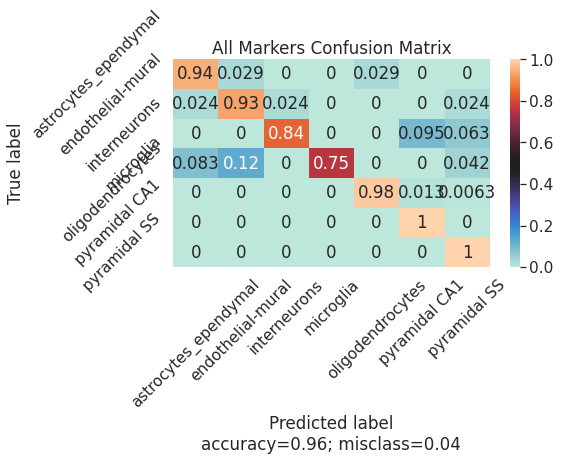

In [32]:
results =  np.load(model_save_path + 'all_markers_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'All Markers Confusion Matrix', save_path = viz_save_path + 'all_markers_cm.pdf', cmap = 'icefire')

### Smash RF

In [33]:
results =  np.load(model_save_path + 'smash_rf_results_{}.npy'.format(1), allow_pickle = True)

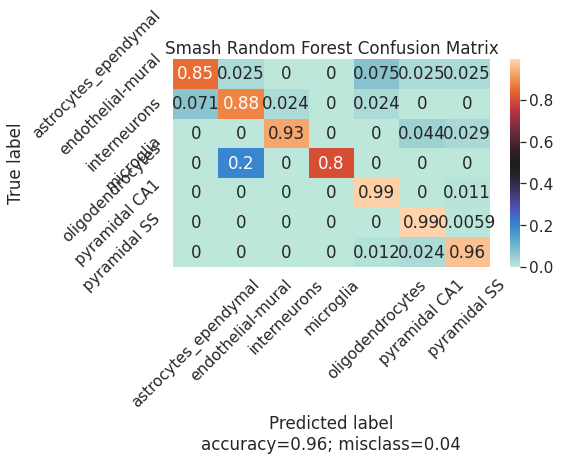

In [34]:
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash Random Forest Confusion Matrix', save_path = viz_save_path + 'smash_rf_cm.pdf', cmap = 'icefire')

### Smash DNN

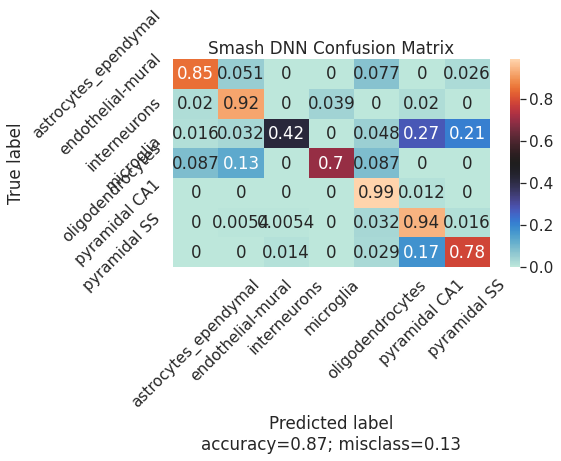

In [35]:
results =  np.load(model_save_path + 'smash_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Smash DNN Confusion Matrix', save_path = viz_save_path + 'smash_cm.pdf', cmap = 'icefire')

### RankCorr

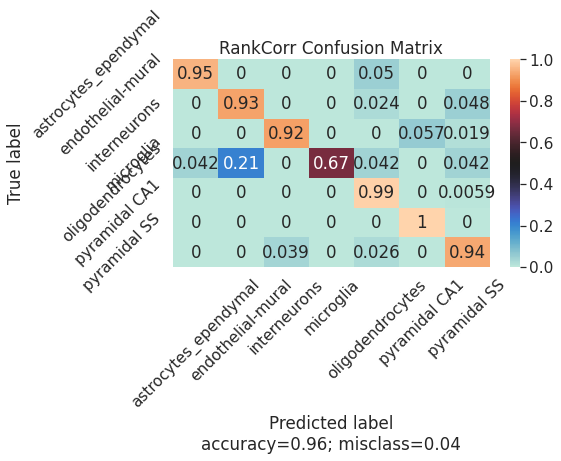

In [36]:
results =  np.load(model_save_path + 'rankcorr_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'RankCorr Confusion Matrix', save_path = viz_save_path + 'rankcorr_cm.pdf', cmap = 'icefire')

### L1 VAE

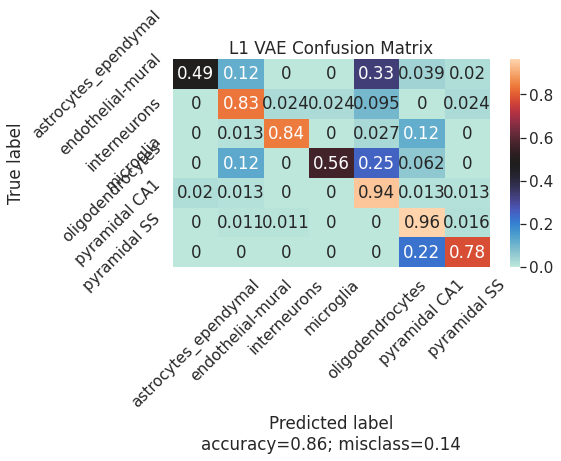

In [37]:
results =  np.load(model_save_path + 'l1_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'L1 VAE Confusion Matrix', save_path = viz_save_path + 'l1_vae_cm.pdf', cmap = 'icefire')

### Global Gate VAE

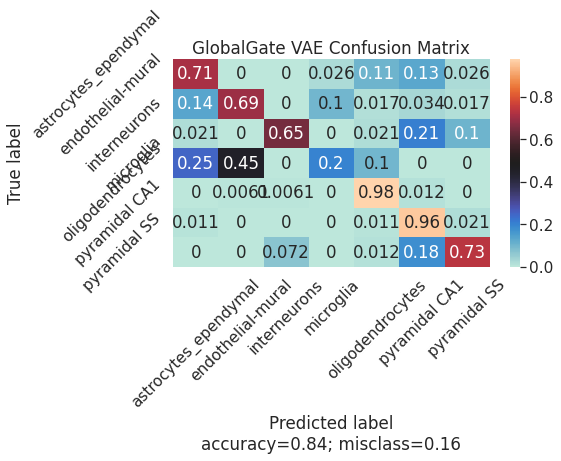

In [38]:
results =  np.load(model_save_path + 'globalgate_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'GlobalGate VAE Confusion Matrix', save_path = viz_save_path + 'globalgate_vae_cm.pdf', cmap = 'icefire')

### MarkerMap Unsupervised

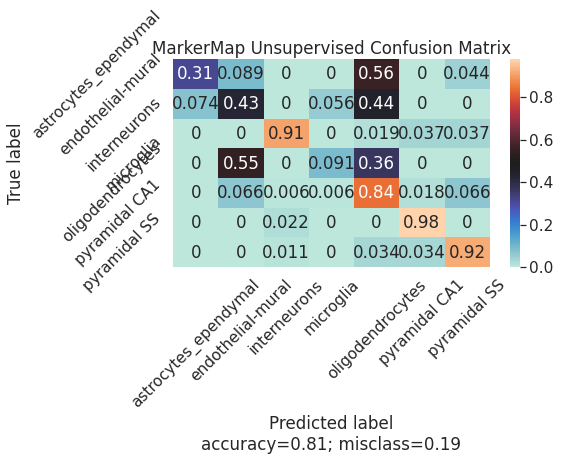

In [39]:
results =  np.load(model_save_path + 'marker_map_unsupervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Unsupervised Confusion Matrix', save_path = viz_save_path + 'marker_map_unsupervised_cm.pdf', cmap = 'icefire')

### MarkerMap Supervised


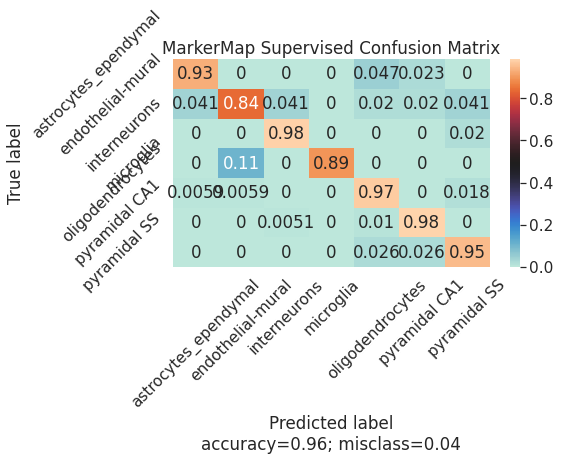

In [40]:
results =  np.load(model_save_path + 'marker_map_supervised_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Supervised Confusion Matrix', save_path = viz_save_path + 'marker_map_supervised_cm.pdf', cmap = 'icefire')

## MarkerMap Mixed Supervision

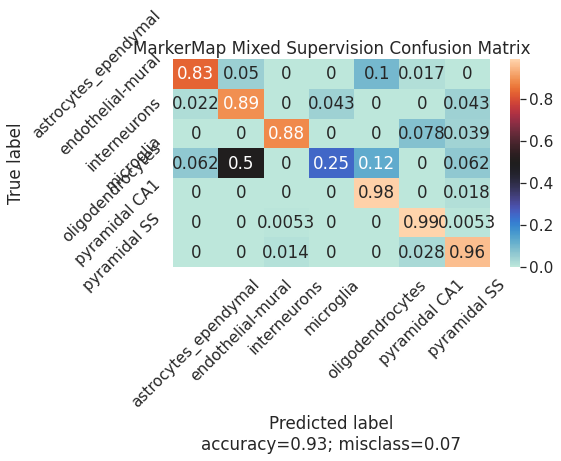

In [41]:
results =  np.load(model_save_path + 'marker_map_mixed_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'MarkerMap Mixed Supervision Confusion Matrix', save_path = viz_save_path + 'marker_map_mixed_cm.pdf', cmap = 'icefire')

### Concrete VAE

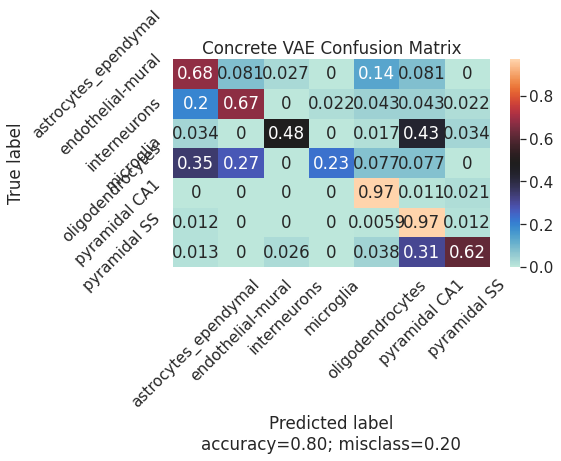

In [42]:
results =  np.load(model_save_path + 'concrete_vae_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'Concrete VAE Confusion Matrix', save_path = viz_save_path + 'concrete_vae_cm.pdf', cmap = 'icefire')

## LassoNet

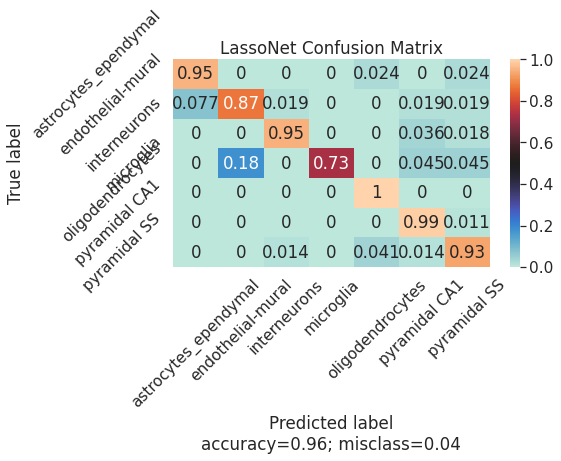

In [43]:
results =  np.load(model_save_path + 'lasso_net_results_{}.npy'.format(1), allow_pickle = True)
plot_confusion_matrix(results[2], encoder.classes_, title = 'LassoNet Confusion Matrix', save_path = viz_save_path + 'lasso_net_cm.pdf', cmap = 'icefire')